# Ames Housing Dataset - EDA and Feature Engineering

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Univariate, Bivariate and Multivariate analysis
* Outliers removal
* Probability Distribution Check
* Feature creation and transformation

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

---

# Explorative Data Analysis
The EDA is the first step to understanding the data and its nature. 

This includes analyzing the single features (Univariate Analysis), their interactions with the target (Bivariate Analysis) and their interactions with other features (Multivariate Analysis and Collinearity Check). 
However, the latter might be hard to compute as it requires the estimation of a regression model that follows certain assumptions and it is usually easier to check this when using linear models.

During my exploration I will look out for possible outliers, correlation and any other statistically relevant problem that might affect my final prediction.

We will start with the environment.

###  Environment, Imports and Global Variables

In [1]:
# Interactive
# %matplotlib notebook
# Static
%matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

### Dataset Loading

In [2]:
# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_0.csv'
ORIG_LABEL = 'ames_housing_out_0_orig.csv'

In [3]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df_orig = pd.read_csv(os.path.join(RESOURCES_DIR, ORIG_LABEL))

df.drop(columns='Unnamed: 0', inplace=True)
df_orig.drop(columns='Unnamed: 0', inplace=True)

In [4]:
def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically 

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

In [5]:
df = sort_alphabetically(df, 'Sale_Price')
df_orig = sort_alphabetically(df_orig, 'Sale_Price')

---

# Univariate Analysis and Feature Transformation

In this part we perform a deeper analysis of the target feature, and some of the most important features (according to the domain knowledge in notebook 0).

Our goal here is to polish the data, by removing outliers and possible confounders that may introduce bias. Furthermore, we need to understand its distribution and normalizing it if possible.

Possibly, we can introduce new variables that are transformations or combinations of other ones, and evaluate their contributions later with a bivariate analysis.

Hopefully, this process will reduce the variance.

## Trying to achieve gaussian like distributions

Normalizing features usually includes three steps:
* Visualization of the data's distribution
* Feature Transformation
* Outliers removal

For the visualization part, we take into consideration all the main numeric features for now and perform 3 types of visualization that can be useful 
* Distribution of values, which should result in a gaussian distribution or at least a distribution that can be transformed into one.
* Scatterplot, which helps us visualize better the tails of the distribution.
* Probability Plot, or QQplot to visualize the quantiles of the gaussian distribution vs the real distribution.

While for categorical features, since it is hard to obtain any new information by the univariate analysis, the analysis will be done against the target feature in the bivariate analysis part

## Treating Outliers

We can think of outliers as influential points that can be seen as *exceptions or rare cases* which have a great impact on our estimations and might be the cause of an increased variance in our results. 

Since we have a great deal of different features there could be many outliers for each one of them when taken one by one. Conversely, this might not be real outliers in the p-dimensional space (considering p predictors).

Since we want to reduce the variance we might as well take our chances and define a general rule to assess outliers, so that our possible error will be uniformly applied to each one of the features and we will be consistent. Again, this might not be possible for each feature as we need to consider the context.


In [6]:
from scipy import stats
from scipy.stats import probplot

def get_df_wo_outliers(dataset: pd.core.frame.DataFrame , label: str, threshold=(0.05,99.95)):
    """
    Returns a copy of the given dataset, after removal of the extreme values specified for a numeric label
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param threshold: tuple of 2 float representing the extremes to drop
    : returns: pd.core.frame.DataFrame
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(threshold) != tuple or len(threshold) != 2) or (type(threshold[0]) != float or type(threshold[1]) != float):
        raise Exception("Threshold must be an float tuple of length 2")
    if threshold[0] > threshold[1]:
        raise Exception("The element in position 0 should smaller than the one in position 1")
    if threshold[0] < 0.0 or threshold[1] > 100.0:
        raise Exception("Threshold out of range")
    
    stats_dict = dataset[label].describe().to_dict()
    uppr = np.percentile(dataset[label].values, float(threshold[1]))
    lwr = np.percentile(dataset[label].values, float(threshold[0]))
    return dataset.loc[(dataset[label] >= lwr) & (dataset[label] < uppr)]


def numeric_distr_plot(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots distribution of the given dataset's column specified in label
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
                               
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label.replace("_", " ") + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.replace("_", " "))
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset: pd.core.frame.DataFrame , label: str):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    fig = plt.figure()
    res = stats.probplot(dataset[label], plot=plt)
    plt.show()
    pass

def scatterplot_distr(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
        
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

## Choose the features to analyze

In [7]:
df.select_dtypes(exclude = object).columns

Index(['Bedroom_AbvGr', 'Bsmt', 'BsmtFin_SF_1', 'BsmtFin_SF_2',
       'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Bsmt_Unf_SF', 'Enclosed_Porch',
       'External_SF', 'Fireplaces', 'First_Flr_SF', 'Full_Bath', 'Garage_Area',
       'Garage_Cars', 'Gr_Liv_Area', 'Half_Bath', 'Kitchen_AbvGr', 'Latitude',
       'Longitude', 'Lot_Area', 'Lot_Frontage', 'LowQ_Total_Liv_Ratio',
       'Low_Qual_Fin_SF', 'Mas_Vnr_Area', 'Mo_Sold', 'Open_Porch_SF',
       'Screen_Porch', 'Second_Flr_SF', 'Three_season_porch', 'TotRms_AbvGrd',
       'Total_Bsmt_Fin_SF', 'Total_Bsmt_SF', 'Wood_Deck_SF', 'Year_Built',
       'Year_Remod_Add', 'Year_Sold', 'Sale_Price'],
      dtype='object')

We are going to focus on more continuous-like features that might be interesting according to our domain research, such as:
* `Sale_Price`
* `Lot_Area`
* `Gr_Liv_Area`, `First_Flr_SF` and `Second_Flr_SF`
* `Total_Bsmt_SF` and `Bsmt_Unf_SF`
* `Garage_Area`

## Sale Price

This attribute is our target, and as such we need to be careful with its transformation as it needs to be invertible.

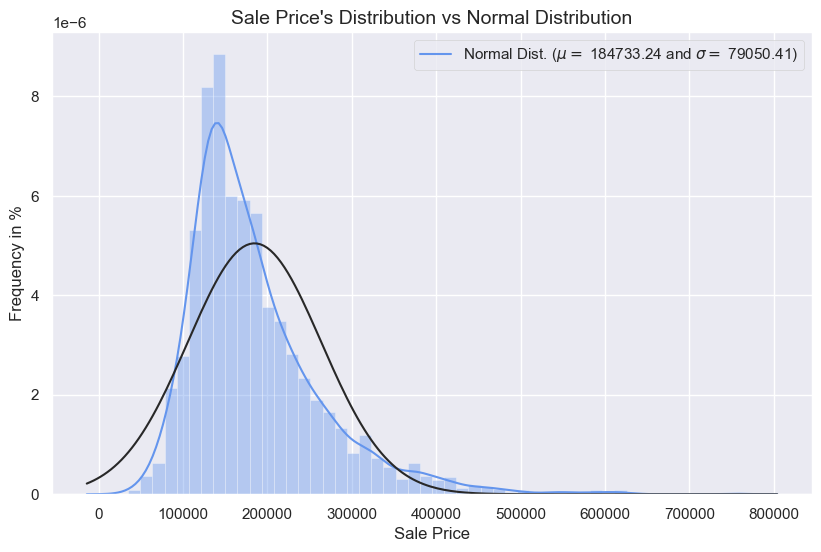

In [8]:
numeric_distr_plot(df, 'Sale_Price')

As we can see the sample distribution highlights quite heavy left tail. As the distribution is similar to a log-normal distribution, let's try and apply this transformation. 

As always, we keep adding them rather then applying the change to the original data. This will make the dataset bulky, but easier to study.

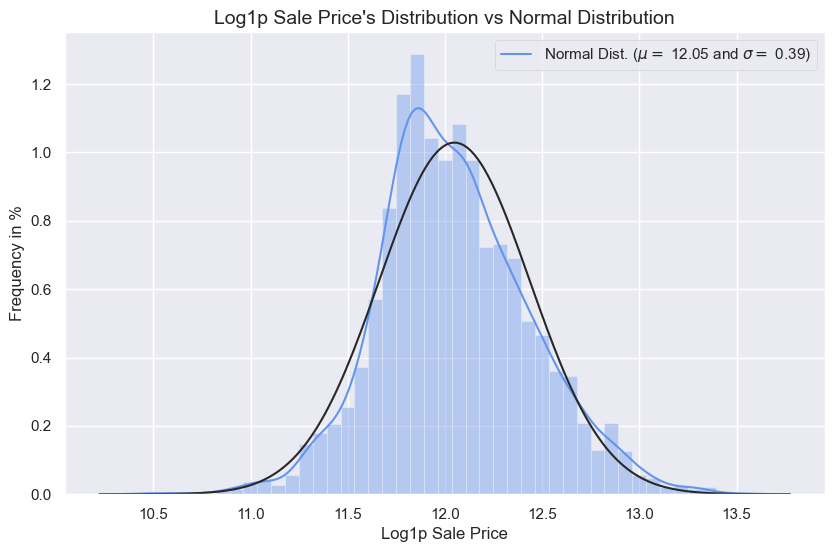

In [9]:
# New feature
df['Log1p_Sale_Price'] = np.log1p(df['Sale_Price'])
df_orig['Log1p_Sale_Price'] = np.log1p(df_orig['Sale_Price'])

numeric_distr_plot(df, 'Log1p_Sale_Price')

The transformation of the target brought the distribution to behave like a gaussian distribution! It is exactly as we predicted. 

Alternatively, there has been evidence of better results with a box-cox transformation, but it is easier to invert the change with the numpy library.

Now, let us focus on the outliers.

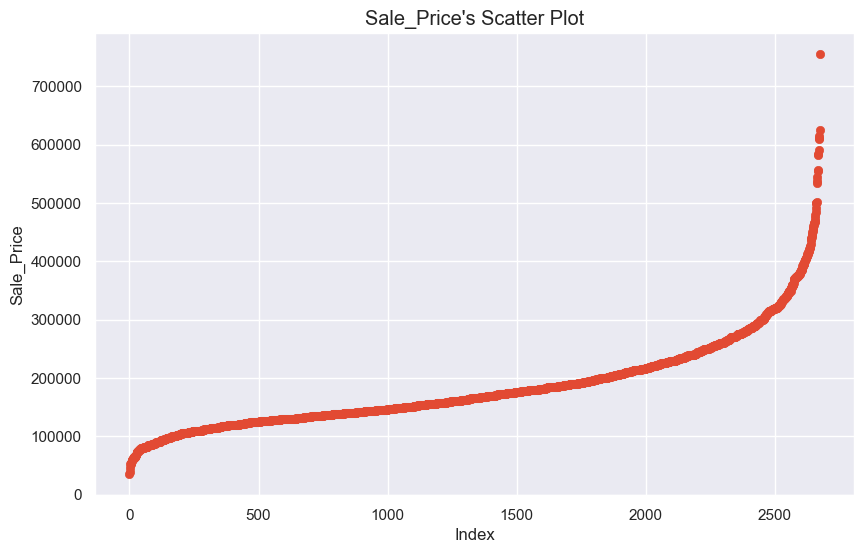

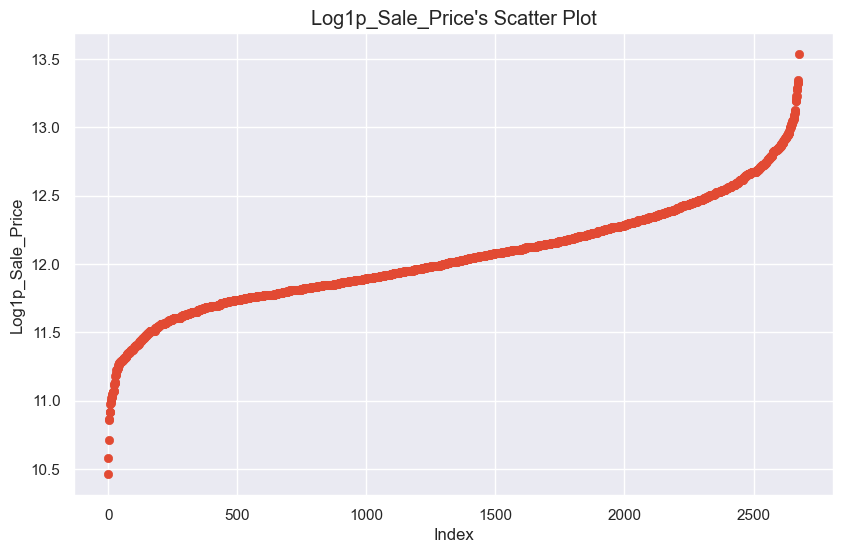

In [10]:
scatterplot_distr(df, 'Sale_Price')
scatterplot_distr(df, 'Log1p_Sale_Price')

There is a great improvement in the distribution

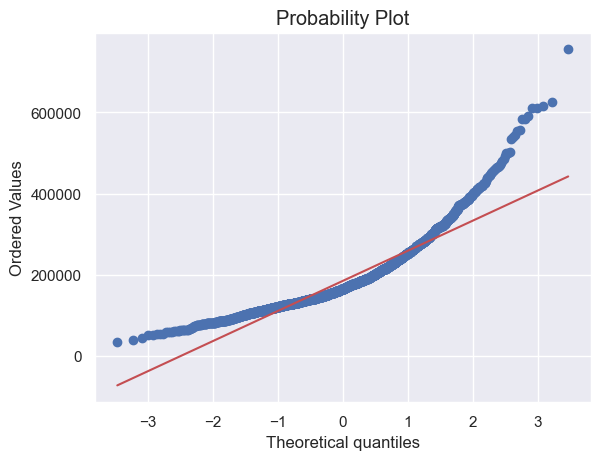

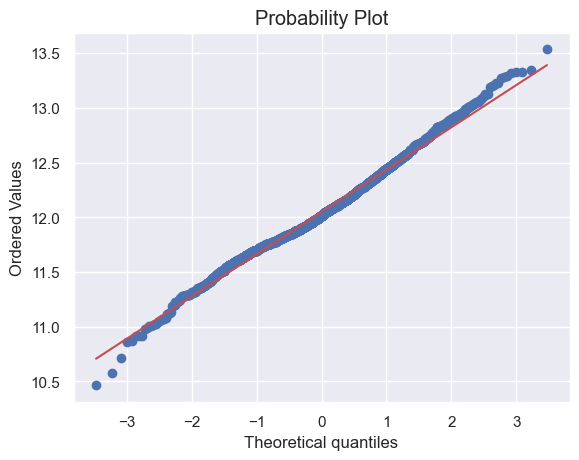

In [11]:
probability_plot(df, 'Sale_Price')
probability_plot(df, 'Log1p_Sale_Price')

This indicates we might need to remove some problematic instances that bring the price too low.

In [12]:
df_wo_outliers = get_df_wo_outliers(df, 'Sale_Price')
df_wo_outliers = get_df_wo_outliers(df_wo_outliers, 'Log1p_Sale_Price')

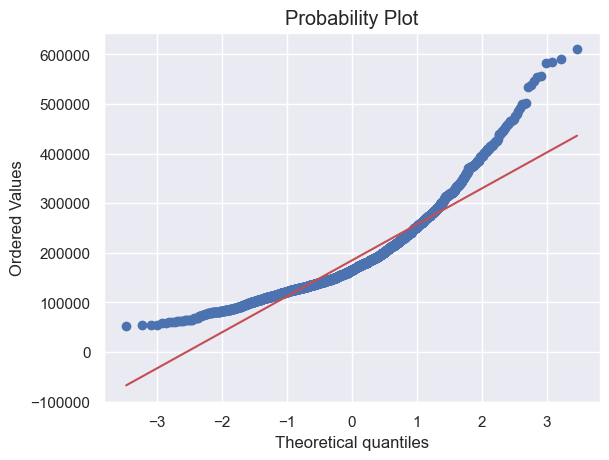

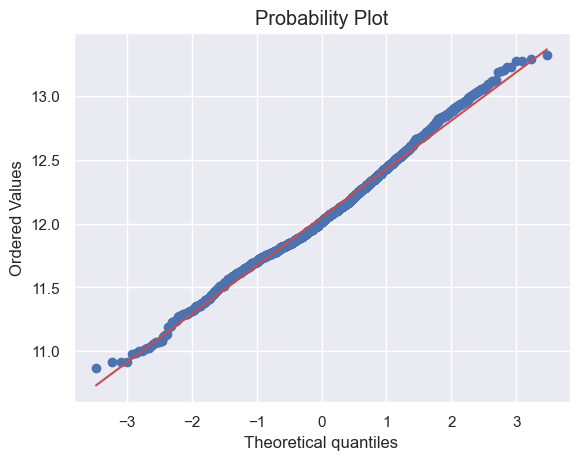

In [13]:
probability_plot(df_wo_outliers, 'Sale_Price')
probability_plot(df_wo_outliers, 'Log1p_Sale_Price')

Nailed it! The probability plot for the target transformation, looks amazing. We are going to keep this version of the dataset and keep removing outliers when possible. 

In [14]:
df = df_wo_outliers

## Lot Area

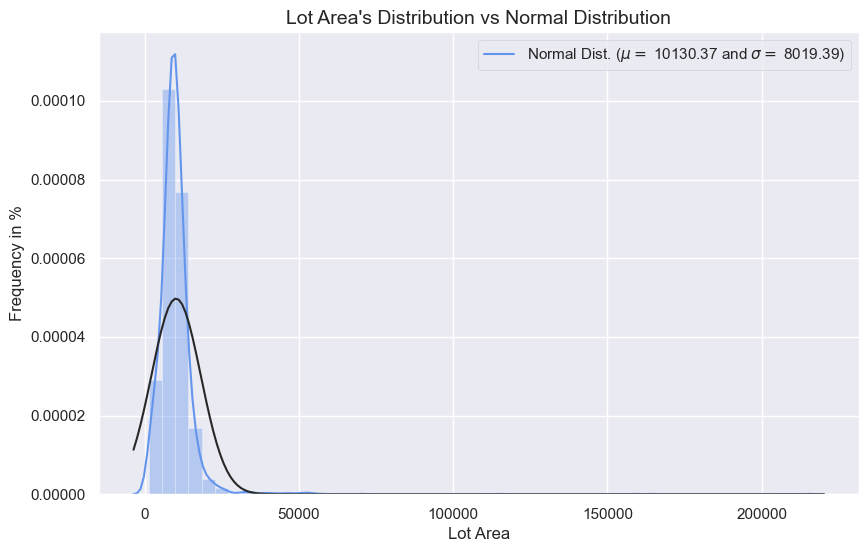

In [15]:
numeric_distr_plot(df, 'Lot_Area')

This looks very bad, some instances with a huge lot area are affecting the distribution

In [16]:
df[df['Lot_Area']>30000]

Bedroom_AbvGr    Bldg_Type  Bsmt  BsmtFin_SF_1  BsmtFin_SF_2  \
0               3.0    b'OneFam'     1           2.0           0.0   
15              4.0    b'OneFam'     1           1.0           0.0   
287             3.0    b'OneFam'     1           2.0         334.0   
466             4.0    b'OneFam'     1           3.0         180.0   
877             3.0    b'OneFam'     1           1.0         820.0   
932             3.0    b'OneFam'     1           7.0           0.0   
1283            2.0    b'OneFam'     1           4.0        1063.0   
1284            2.0    b'OneFam'     1           2.0           0.0   
1288            5.0    b'OneFam'     1           7.0           0.0   
1373            5.0    b'OneFam'     0           0.0           0.0   
1374            3.0    b'OneFam'     1           3.0           0.0   
1435            3.0  b'TwoFmCon'     1           1.0         147.0   
1496            4.0    b'OneFam'     1           3.0           0.0   
1497            3.0  b'TwoFmCon'     1           1.0           0.0   
1904            2.0    b'OneFam'     1           3.0           0.0   
1947            4.0    b'OneFam'     1           6.0           0.0   
1948            3.0    b'OneFam'     1           3.0           0.0   
2010            2.0    b'OneFam'     1           3.0           0.0   
2011            3.0    b'OneFam'     1           3.0           0.0   
2054            4.0    b'OneFam'     1           6.0           0.0   
2093            3.0    b'OneFam'     1           6.0           0.0   
2098            2.0    b'OneFam'     0           0.0           0.0   
2102            3.0  b'TwoFmCon'     1           2.0           0.0   
2114            3.0    b'OneFam'     1           1.0           0.0   
2155            3.0  b'TwoFmCon'     1           6.0           0.0   
2329            2.0    b'OneFam'     1           3.0           0.0   
2467            5.0    b'OneFam'     1           7.0           0.0   
2533            4.0    b'OneFam'     1           6.0           0.0   
2535            2.0    b'OneFam'     1           1.0           0.0   
2646            2.0    b'OneFam'     1           2.0           0.0   

      BsmtFin_Type_1  BsmtFin_Type_2       Bsmt_Cond   Bsmt_Exposure  \
0             b'BLQ'          b'Unf'         b'Good'           b'Gd'   
15            b'ALQ'          b'Unf'      b'Typical'           b'Gd'   
287           b'BLQ'          b'Rec'      b'Typical'           b'Av'   
466           b'GLQ'          b'Rec'         b'Good'           b'No'   
877           b'ALQ'          b'Rec'      b'Typical'           b'Gd'   
932           b'Unf'          b'Unf'      b'Typical'           b'No'   
1283          b'LwQ'          b'GLQ'      b'Typical'           b'Gd'   
1284          b'BLQ'          b'Unf'      b'Typical'           b'Gd'   
1288          b'Unf'          b'Unf'      b'Typical'           b'No'   
1373  b'No_Basement'  b'No_Basement'  b'No_Basement'  b'No_Basement'   
1374          b'GLQ'          b'Unf'      b'Typical'           b'Gd'   
1435          b'ALQ'          b'BLQ'      b'Typical'           b'Gd'   
1496          b'GLQ'          b'Unf'      b'Typical'           b'Av'   
1497          b'ALQ'          b'Unf'      b'Typical'           b'Gd'   
1904          b'GLQ'          b'Unf'      b'Typical'           b'Gd'   
1947          b'Rec'          b'Unf'      b'Typical'           b'Gd'   
1948          b'GLQ'          b'Unf'      b'Typical'           b'Av'   
2010          b'GLQ'          b'Unf'      b'Typical'           b'Gd'   
2011          b'GLQ'          b'Unf'      b'Typical'           b'Gd'   
2054          b'Rec'          b'Unf'      b'Typical'           b'No'   
2093          b'Rec'          b'Unf'      b'Typical'           b'Gd'   
2098  b'No_Basement'  b'No_Basement'  b'No_Basement'  b'No_Basement'   
2102          b'BLQ'          b'Unf'      b'Typical'           b'Av'   
2114          b'ALQ'          b'Unf'      b'Typical'           b'Mn'   
2155          b'Rec'          b'Unf

There are very few observations with such values, and their rarity makes them safe to delete. This will be later done with bivariate analysis, where we can see if some those instances are still tollerable.

This is what it would look like if we removed those outliers:

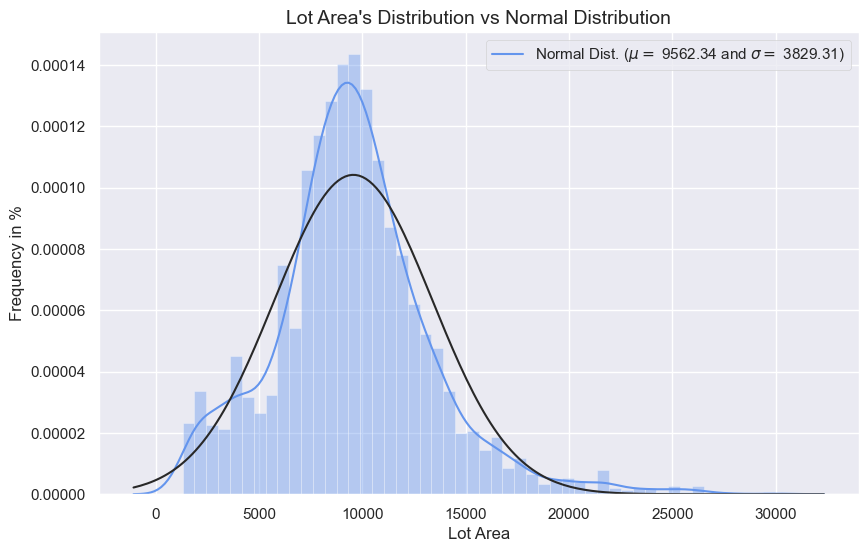

In [17]:
numeric_distr_plot(df.drop(df[df['Lot_Area']>30000].index.tolist()), 'Lot_Area')

Here, the feature does not look like it needs a transformation.

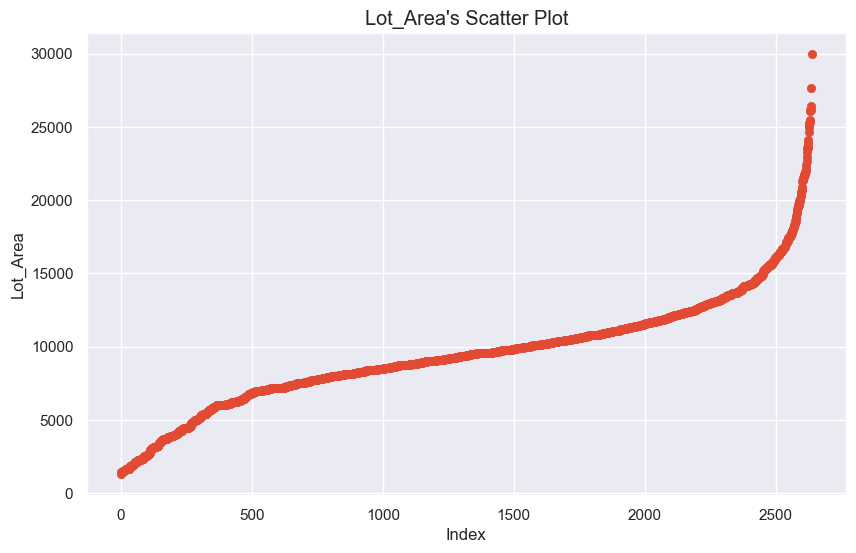

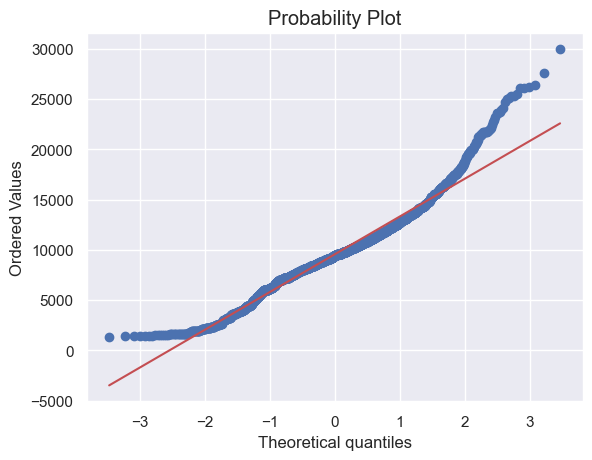

In [18]:
scatterplot_distr(df.drop(df[df['Lot_Area']>30000].index.tolist()), 'Lot_Area')
probability_plot(df.drop(df[df['Lot_Area']>30000].index.tolist()), 'Lot_Area')

However, the tails are still problematic! 

Most observations do not go over the value `15000`, but identifying outliers for this aspect requires a comparison with the price.

## Above Ground Living Area

As the above ground living area is the sum of `First_Flr_SF`, `'Second_Flr_SF`,`Low_Qual_Fin_SF` I will avoid to remove outliers from these three attributes as it might lead to problematic results

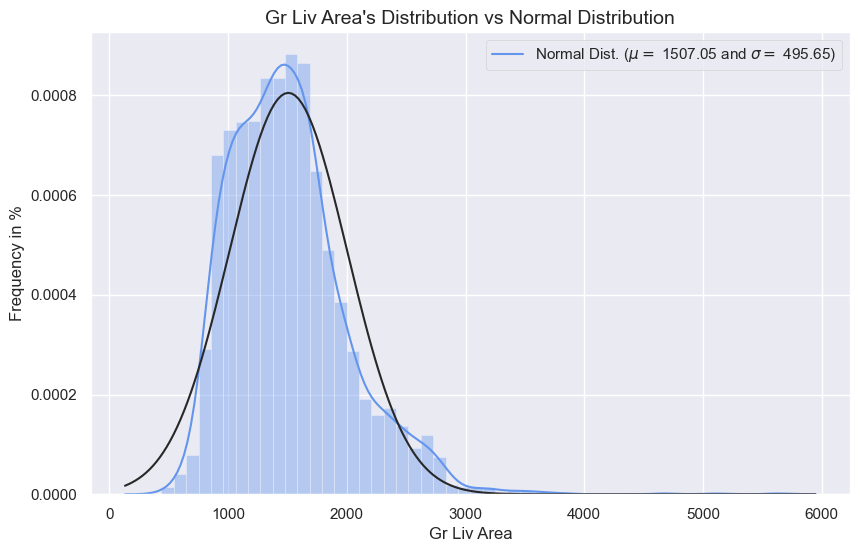

In [19]:
numeric_distr_plot(df, 'Gr_Liv_Area')

It seems like we could use our log-transformation again

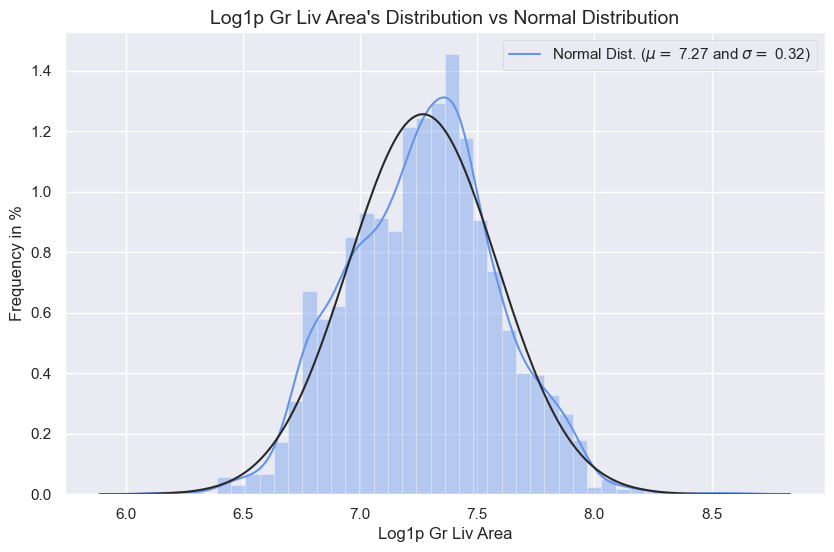

In [20]:
df['Log1p_Gr_Liv_Area'] = np.log1p(df['Gr_Liv_Area'])
df_orig['Log1p_Gr_Liv_Area'] = np.log1p(df_orig['Gr_Liv_Area'])

numeric_distr_plot(df, 'Log1p_Gr_Liv_Area')

In fact, the transformation really helps us. 

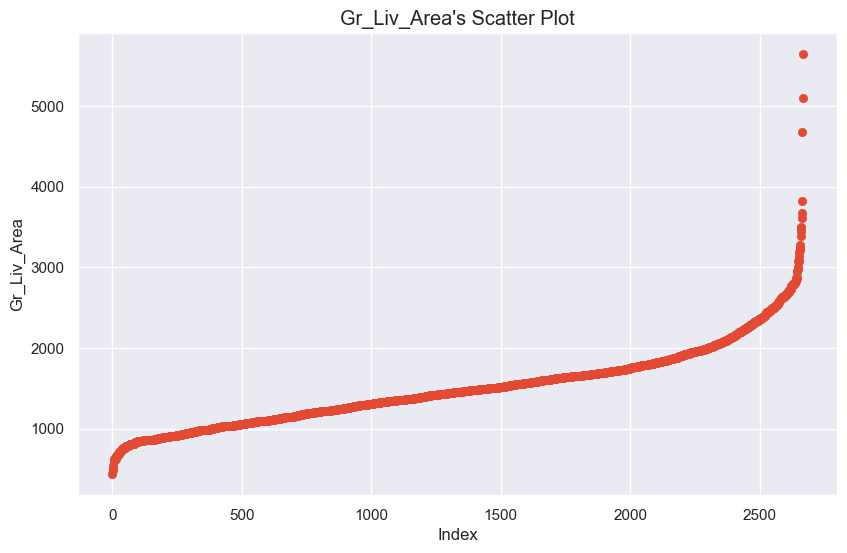

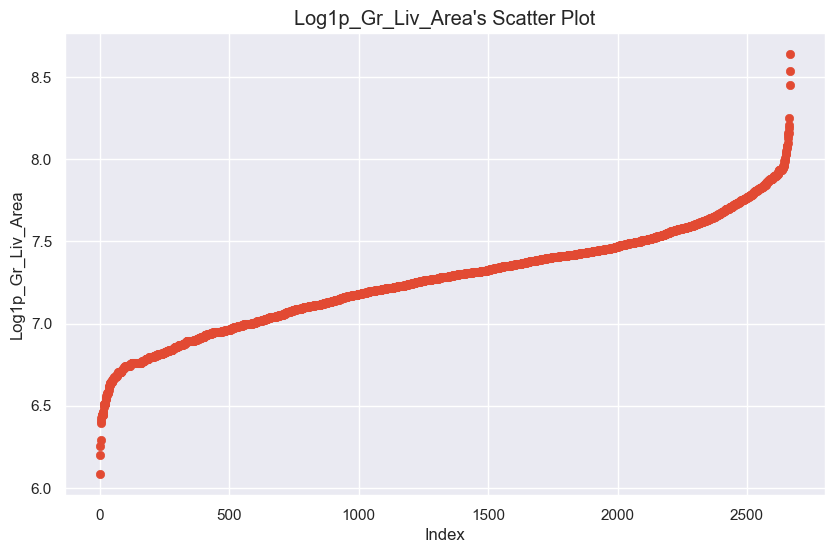

In [21]:
scatterplot_distr(df, 'Gr_Liv_Area')
scatterplot_distr(df, 'Log1p_Gr_Liv_Area')

The plots show some problematic points, which require a comparison with price (trivially) to assess whether they are outliers

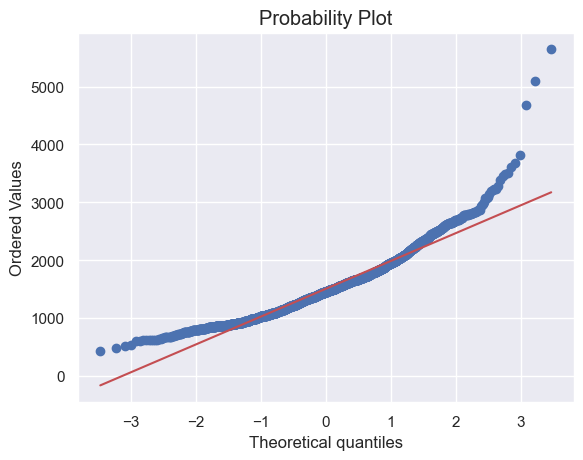

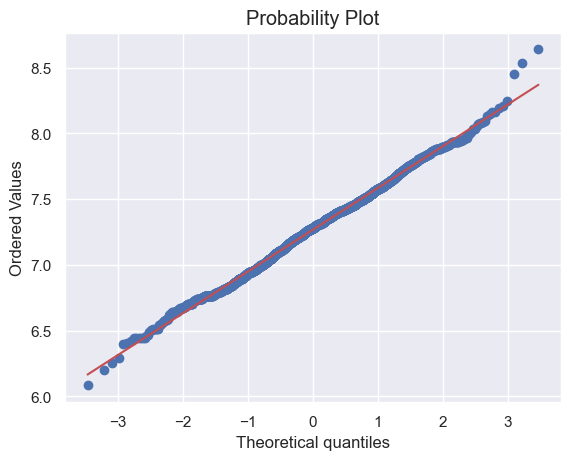

In [22]:
probability_plot(df, 'Gr_Liv_Area')
probability_plot(df, 'Log1p_Gr_Liv_Area')

From the QQplot, we can tell some of those instances could be useful observations to represent extreme values in the models

### First Floor SquareFeet

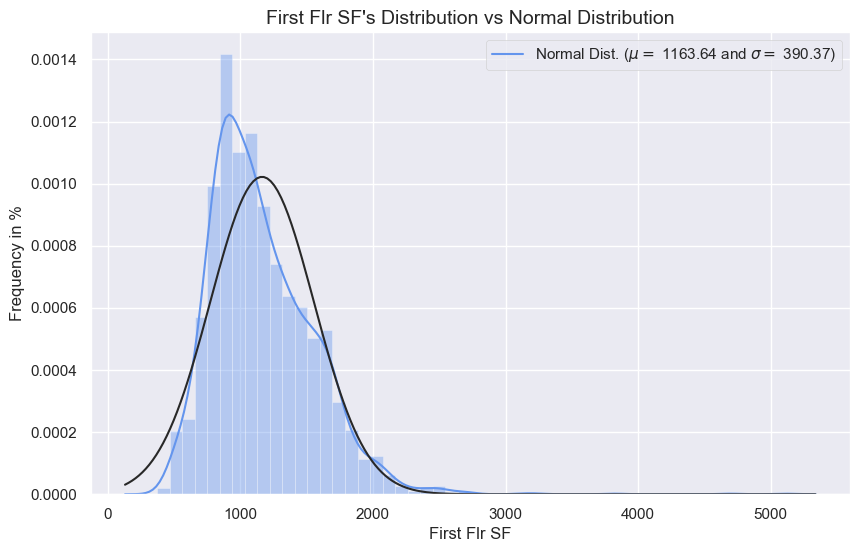

In [23]:
numeric_distr_plot(df, 'First_Flr_SF')

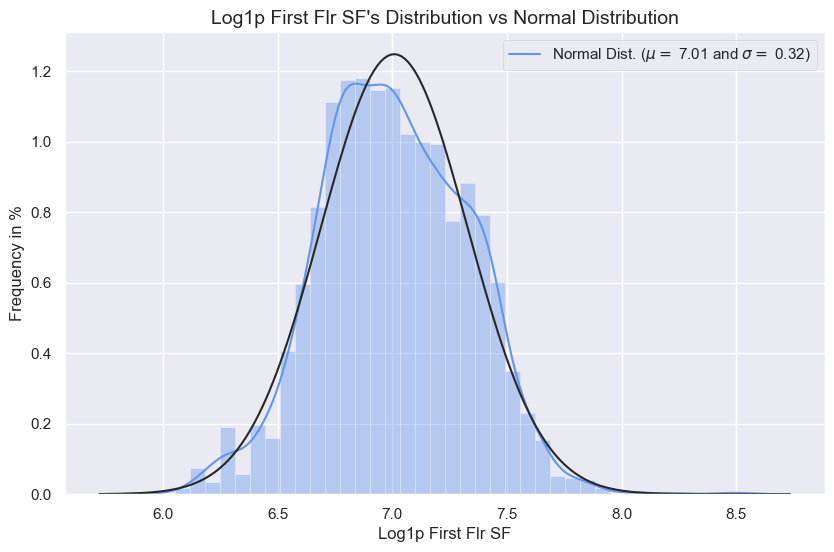

In [24]:
df['Log1p_First_Flr_SF'] = np.log1p(df['First_Flr_SF'])
df_orig['Log1p_First_Flr_SF'] = np.log1p(df_orig['First_Flr_SF'])


numeric_distr_plot(df, 'Log1p_First_Flr_SF')

The transformation perfectly centers the feature around the value `7.0`

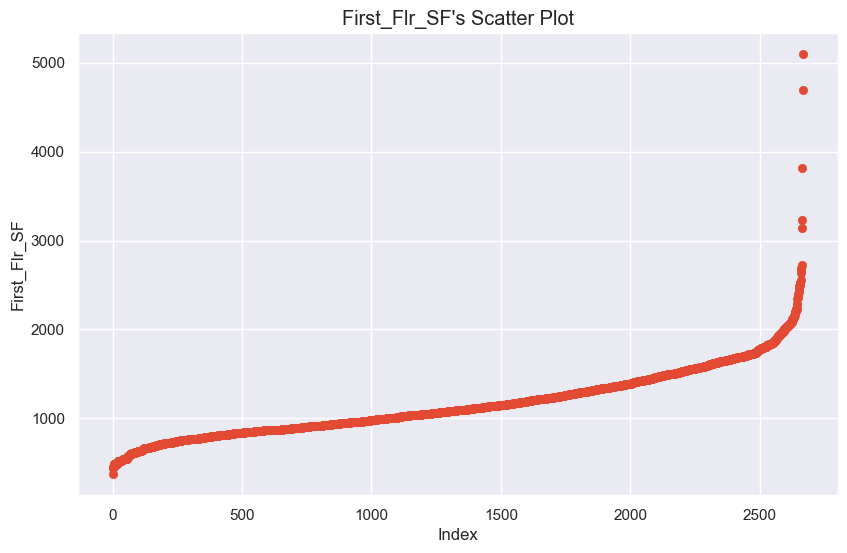

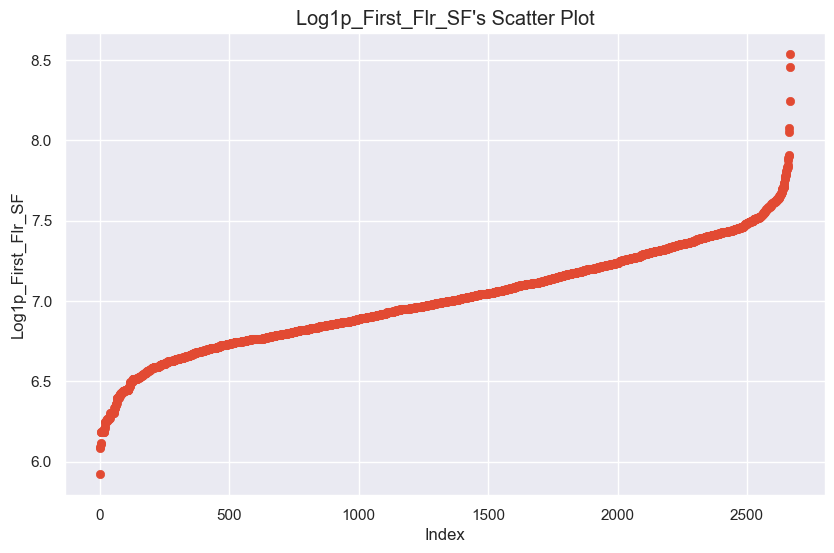

In [25]:
scatterplot_distr(df,'First_Flr_SF')
scatterplot_distr(df,'Log1p_First_Flr_SF')

The transformation looks great, besides some outliers which are shown in the tails of the probability plots

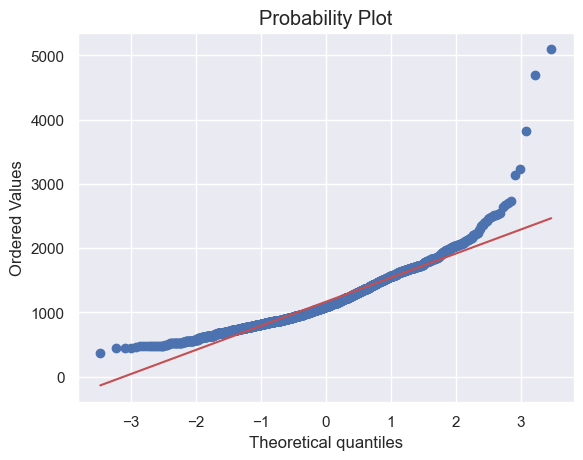

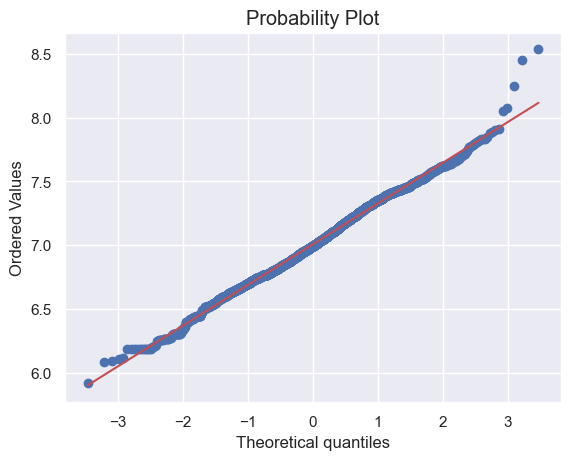

In [26]:
probability_plot(df, 'First_Flr_SF')
probability_plot(df, 'Log1p_First_Flr_SF')

Since they are still aligned with the theoretical quantiles we want to keep them as useful evidence. However, 
* The left tail presents some problematic points between `-2` and `-3`
* While the right tail shows very odd entries after the theoretical quantiles take value `3`

### Second Floor Square Feet

Some features like the following ones tend to have many instances which take value `0.0` as they either lack that information or they do not have that feature at all. This is why we will focus on the distribution and ignore those instances.

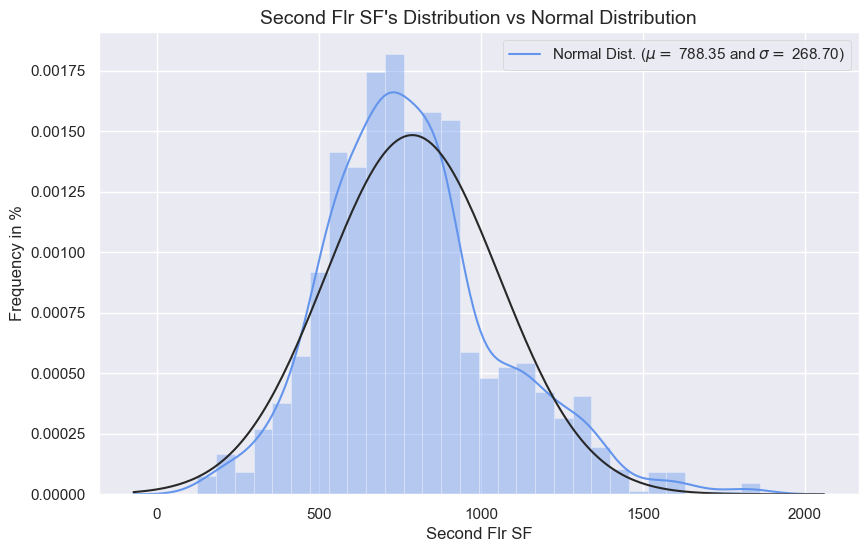

In [27]:
numeric_distr_plot(df.drop(df[df['Second_Flr_SF']==0.0].index.tolist()), 'Second_Flr_SF')

The distribution appears to have a very steep change when approaching the `1000` square feet. This obviously depends by the construction details of the houses (something we can only measure to some extent). We could say it looks good enough, but the scatterplot and the probability plot highlight some issues in the right tail.

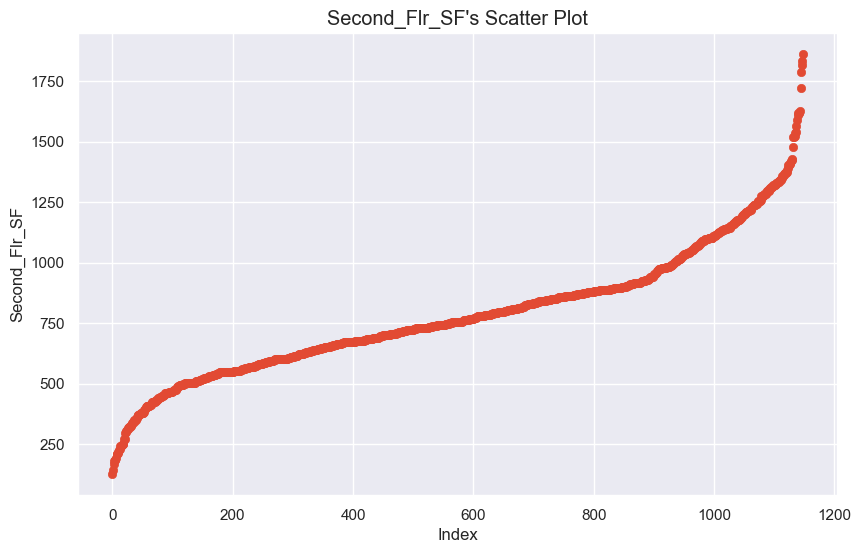

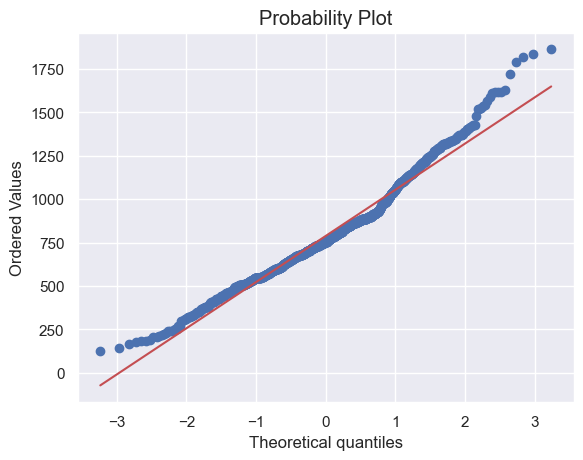

In [28]:
scatterplot_distr(df.drop(df[df['Second_Flr_SF']==0.0].index.tolist()), 'Second_Flr_SF')
probability_plot(df.drop(df[df['Second_Flr_SF']==0.0].index.tolist()), 'Second_Flr_SF')

Removing those outliers would not be a specular operation, as we can see from the plot. We might need to investigate more.

## Total Basement Square Feet

Again there are many entries without basements and we are going to focus on those who do not lack that information

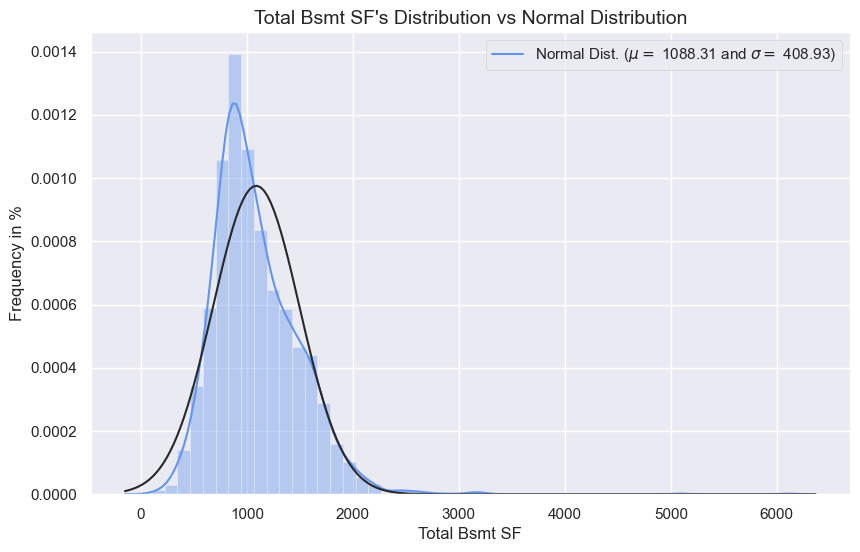

In [29]:
numeric_distr_plot(df.drop(df[df['Total_Bsmt_SF']==0.0].index.tolist()), 'Total_Bsmt_SF')

Curiously enough, this distribution is really similar to the one seen with `First_Flr_SF`. It is safe to assume that their area is very similar for most instances.

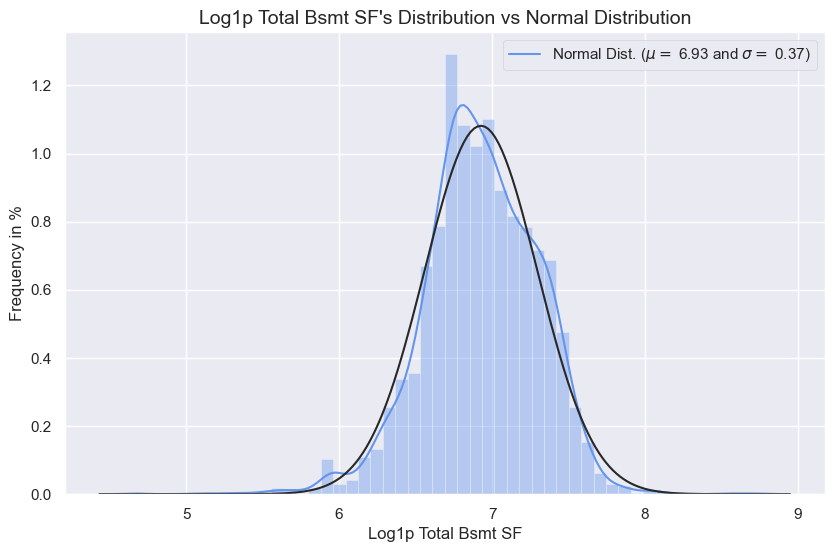

In [30]:
df['Log1p_Total_Bsmt_SF'] = np.log1p(df['Total_Bsmt_SF'])
df_orig['Log1p_Total_Bsmt_SF'] = np.log1p(df_orig['Total_Bsmt_SF'])

numeric_distr_plot(df.drop(df[df['Log1p_Total_Bsmt_SF']==0.0].index.tolist()), 'Log1p_Total_Bsmt_SF')

The transformation looks good to, but the tails of the distributions can really be problematic

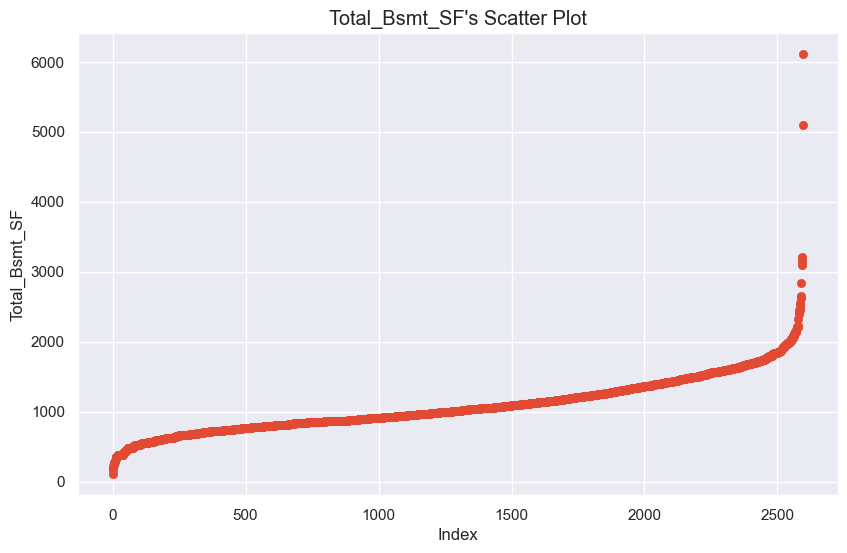

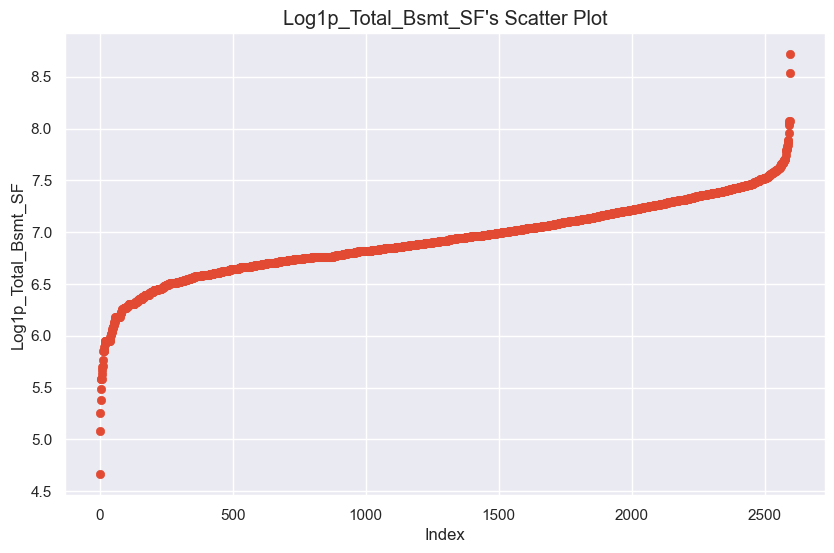

In [31]:
scatterplot_distr(df.drop(df[df['Bsmt']==0].index.tolist()), 'Total_Bsmt_SF')
scatterplot_distr(df.drop(df[df['Bsmt']==0].index.tolist()), 'Log1p_Total_Bsmt_SF')

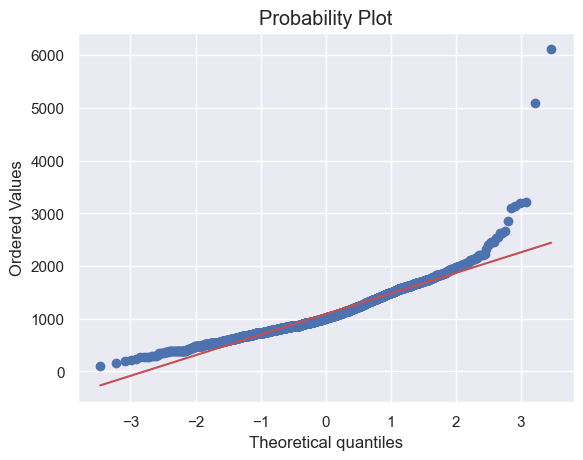

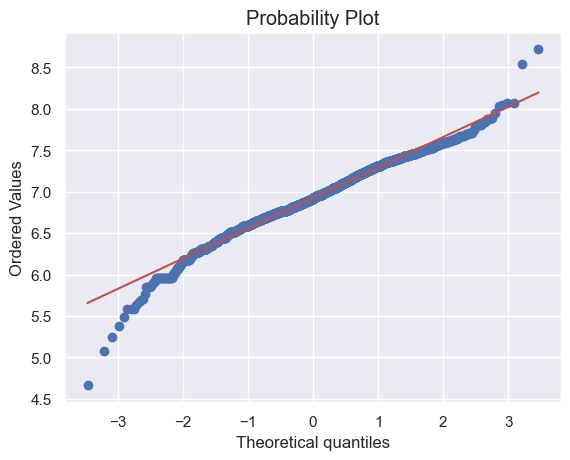

In [32]:
probability_plot(df.drop(df[df['Total_Bsmt_SF']==0.0].index.tolist()), 'Total_Bsmt_SF')
probability_plot(df.drop(df[df['Log1p_Total_Bsmt_SF']==0.0].index.tolist()), 'Log1p_Total_Bsmt_SF')

It is hard to choose the best option between the two from the QQplot, but the distributions suggest that after a careful removal of outliers, the transformed feature might be better. 

In [33]:
df[(df['Log1p_Total_Bsmt_SF'] < 6.0) & (df['Log1p_Total_Bsmt_SF'] > 4.5)]['Bsmt_Unf_SF']

52       58.0
55      134.0
171     346.0
191     360.0
290     384.0
319     100.0
321     384.0
326     195.0
438     384.0
448      30.0
451     384.0
455     384.0
625     160.0
643     240.0
656     190.0
673     297.0
684     264.0
836       0.0
901       0.0
1126    228.0
1165    105.0
1204    346.0
1253    319.0
1440    352.0
1441    384.0
1456    264.0
1479    384.0
1481    206.0
1486    384.0
1487    384.0
1519     23.0
1606    384.0
1610    384.0
1752    226.0
1784      0.0
1974      0.0
2055    279.0
2383    216.0
2384     30.0
2471    396.0
2659    264.0
Name: Bsmt_Unf_SF, dtype: float64

There are a good amount of houses which have unfinished basements and that is probably what is causing these issues. I want to set this aside for later as we can use a bivariate analysis to better check the issues.

### Basement Unfinished  Square Feet

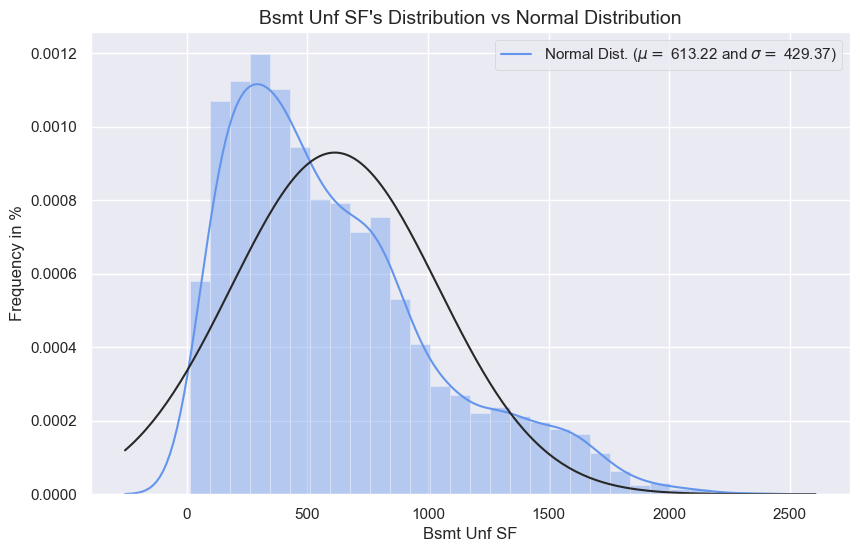

In [34]:
numeric_distr_plot(df.drop(df[df['Bsmt_Unf_SF']==0.0].index.tolist()), 'Bsmt_Unf_SF')

The distribution does not look like it might be helpful.

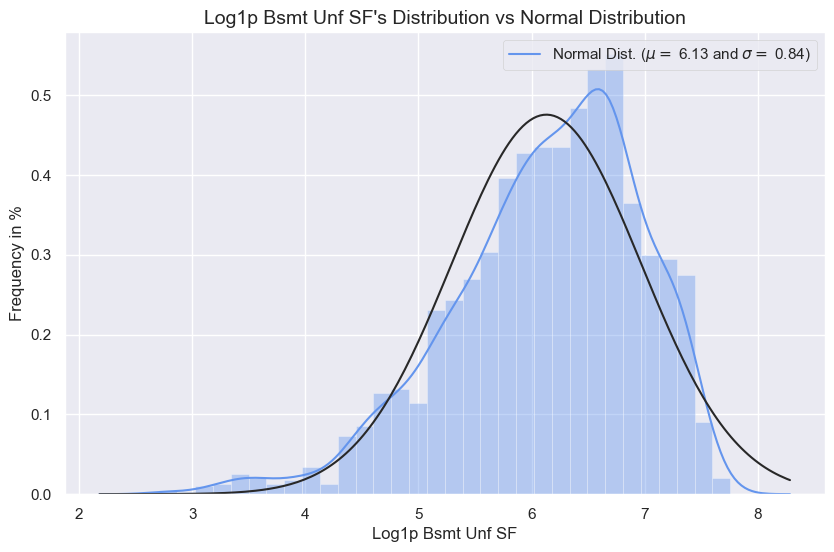

In [35]:
df['Log1p_Bsmt_Unf_SF'] = np.log1p(df['Bsmt_Unf_SF'])
df_orig['Log1p_Bsmt_Unf_SF'] = np.log1p(df_orig['Bsmt_Unf_SF'])

numeric_distr_plot(df.drop(df[df['Log1p_Bsmt_Unf_SF']==0.0].index.tolist()), 'Log1p_Bsmt_Unf_SF')

The shape does get some improvements but the variance is too high and it looks like we have shifted the problem to the right, by creating a triangular distribution or an ARGUS distribution. Furthermore, it might look more gaussian by removing some outliers.

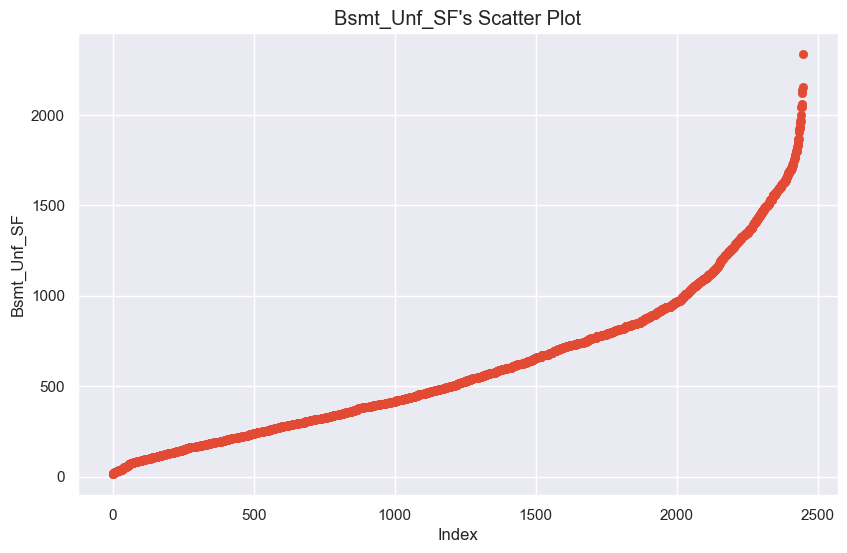

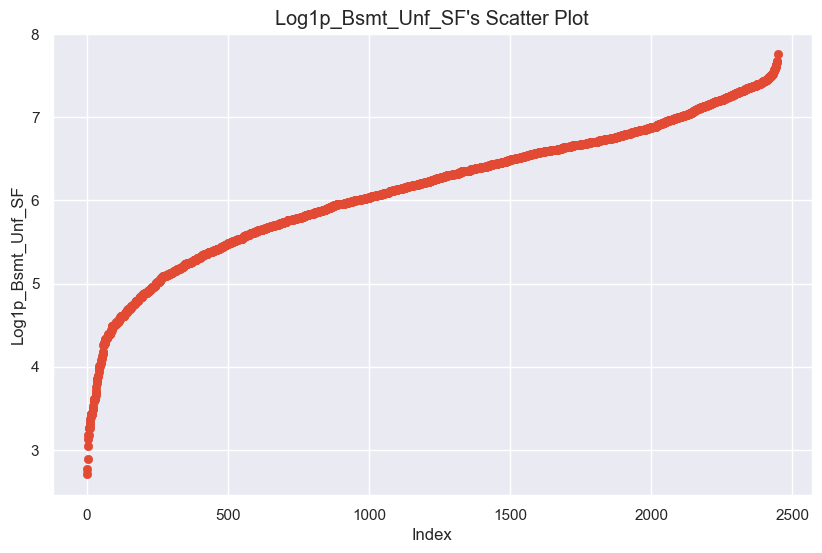

In [36]:
scatterplot_distr(df.drop(df[df['Bsmt_Unf_SF']==0.0].index.tolist()), 'Bsmt_Unf_SF')
scatterplot_distr(df.drop(df[df['Log1p_Bsmt_Unf_SF']==0.0].index.tolist()), 'Log1p_Bsmt_Unf_SF')

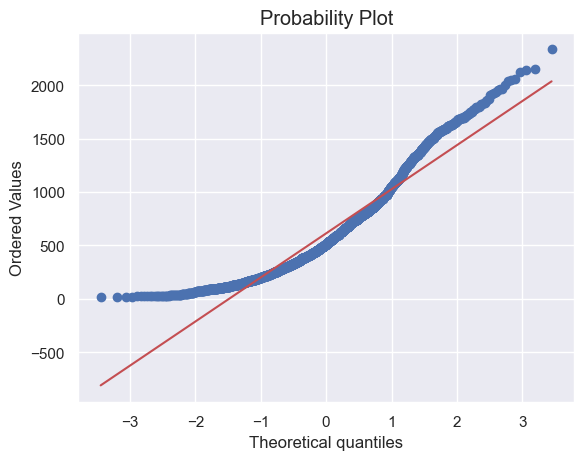

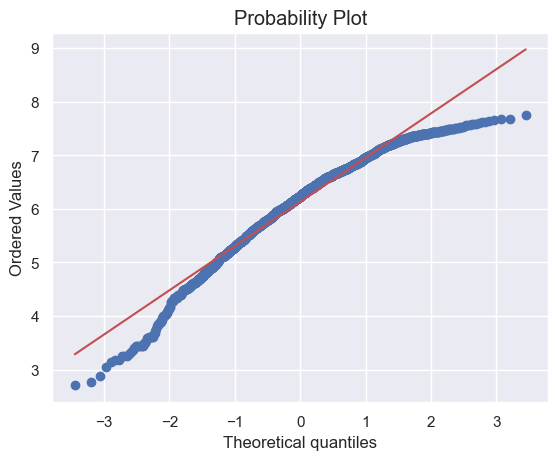

In [37]:
probability_plot(df.drop(df[df['Bsmt_Unf_SF']==0.0].index.tolist()), 'Bsmt_Unf_SF')
probability_plot(df.drop(df[df['Log1p_Bsmt_Unf_SF']==0.0].index.tolist()), 'Log1p_Bsmt_Unf_SF')

Once more, it seems we have to wait for the bivariate analysis

## Garage Area

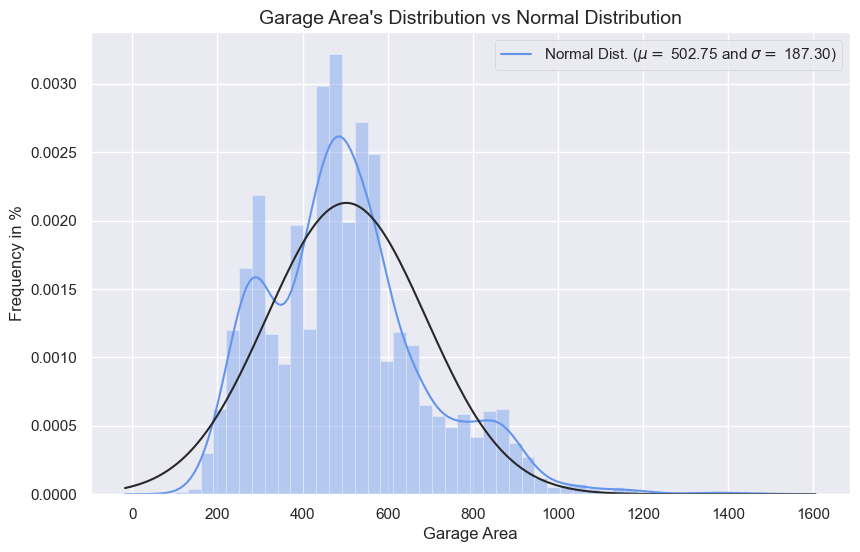

In [38]:
numeric_distr_plot(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')

This is an interesting pattern but not transformation can improve this shape.

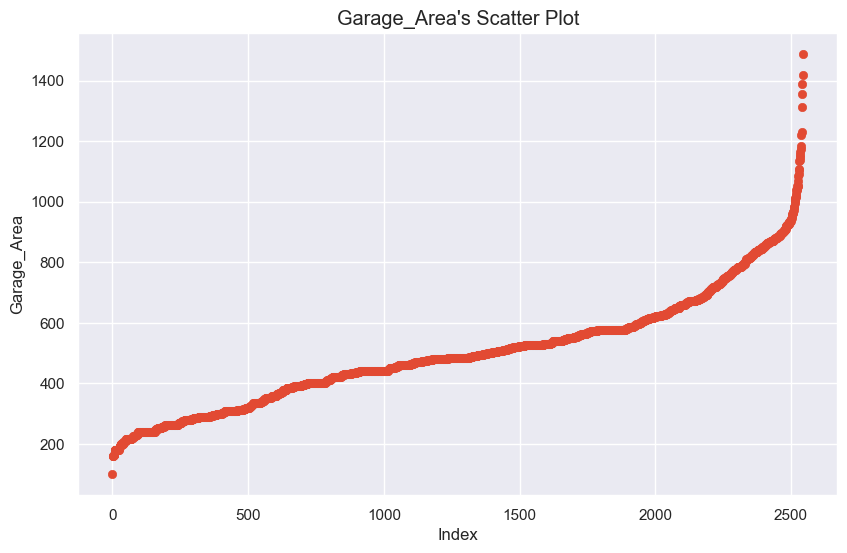

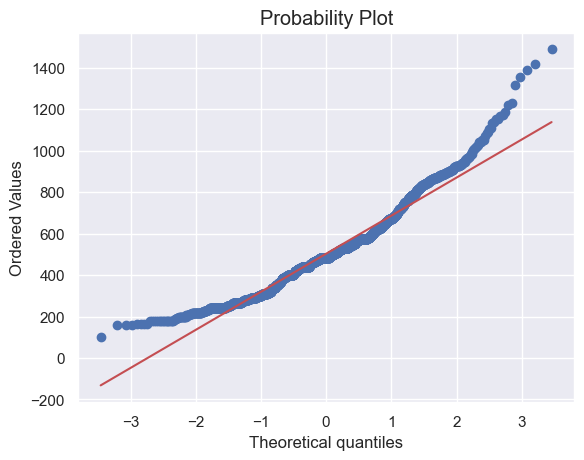

In [39]:
scatterplot_distr(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')
probability_plot(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')

We have instances of very heavy right tails that need to be studied.

---

# Bivariate and Multivariate Analysis

## Correlation

Before choosing what features to inspect in depth, we look at the correlation and we discard the outliers.
Furthermore if we find that a transformation or a new feature could represent a better fit, we will add it and try to see how that would be of use.

In [40]:
def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

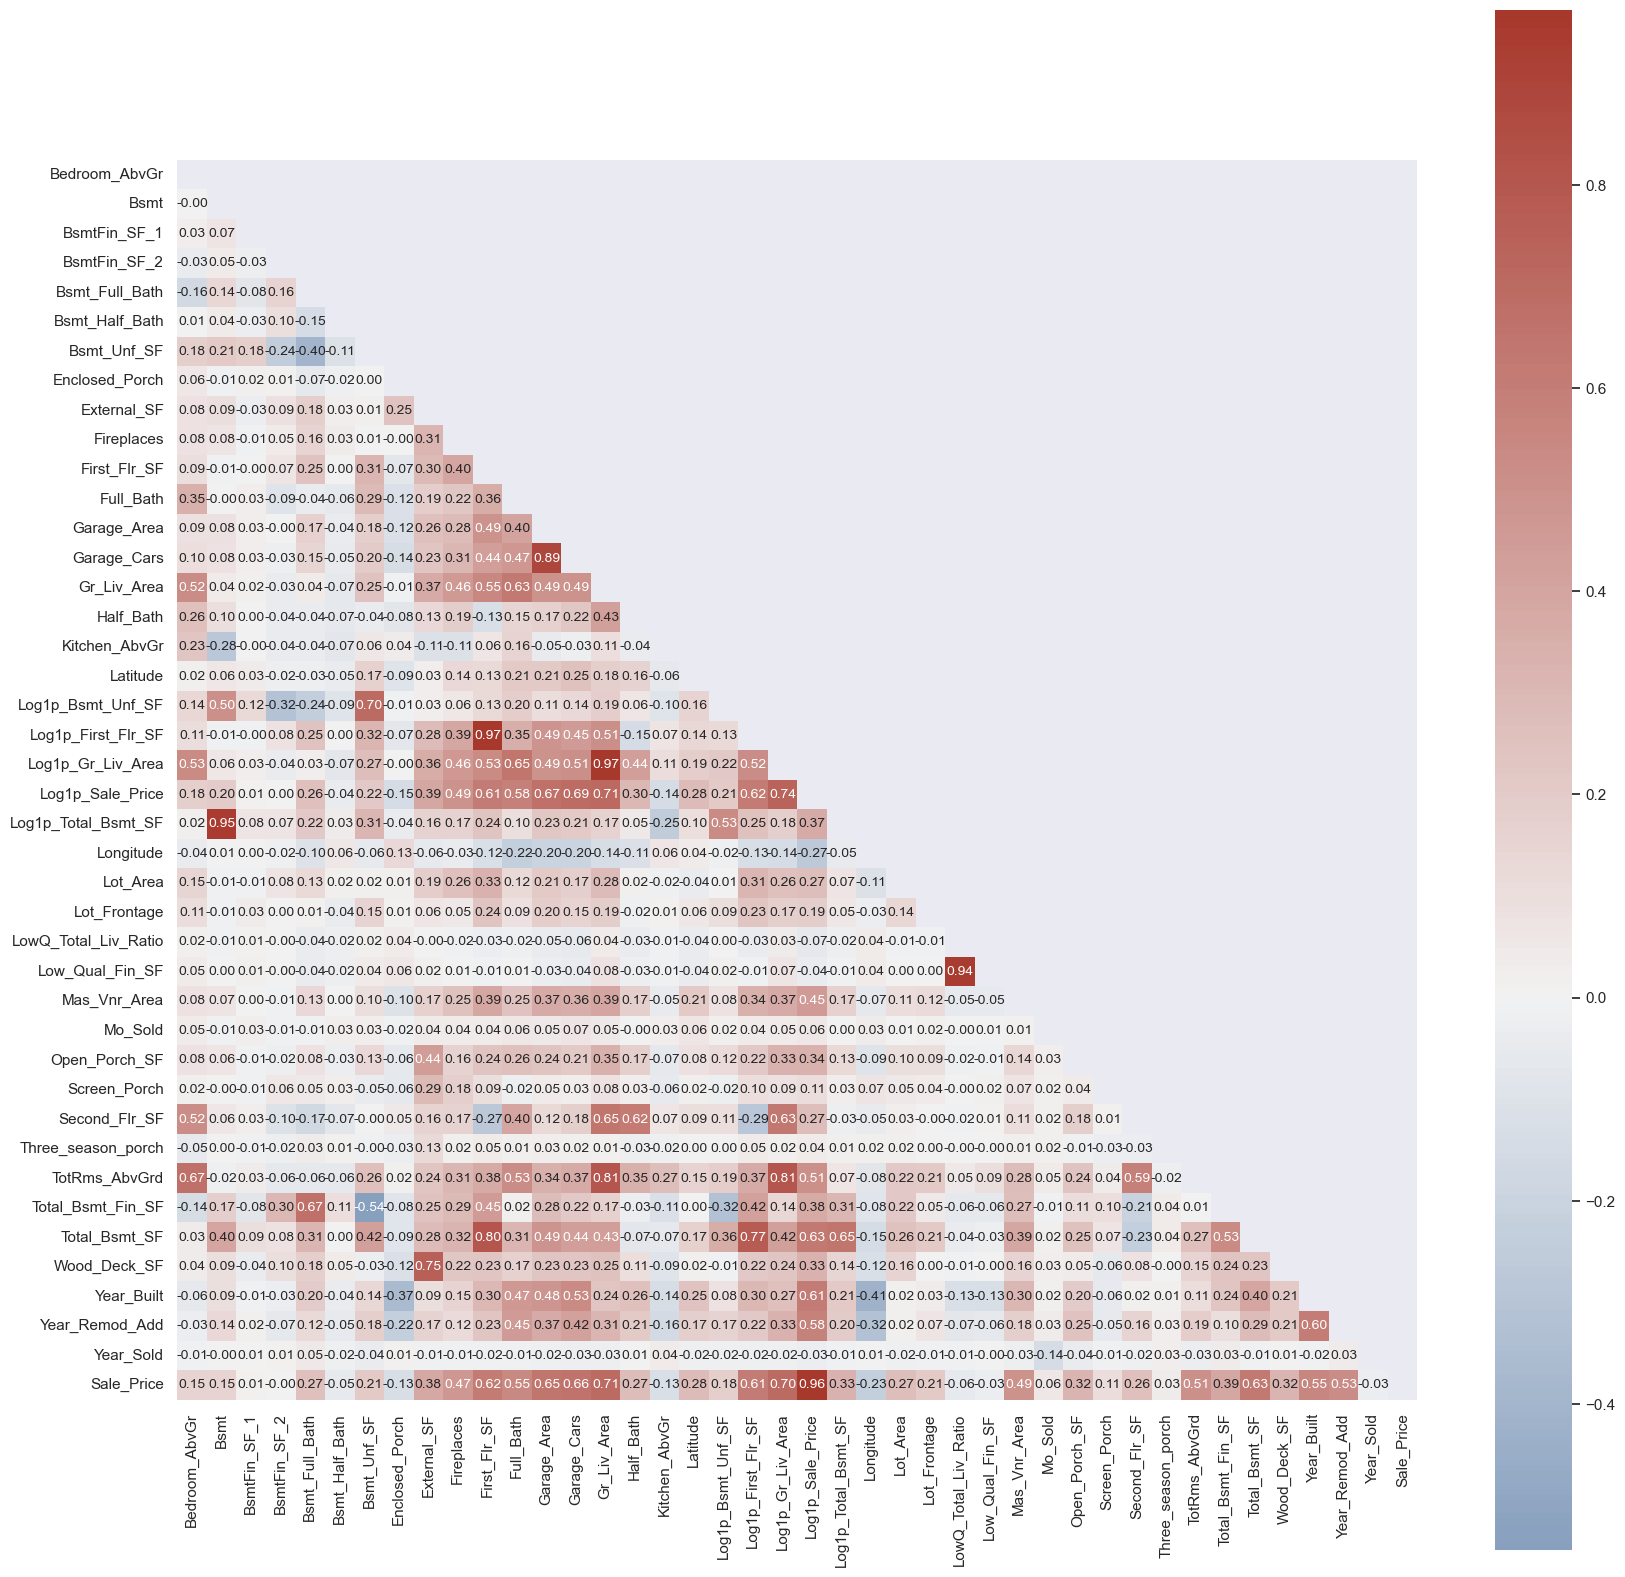

In [41]:
corr = display_corr_matrix(sort_alphabetically(df, 'Sale_Price'), label='Sale_Price')

In [42]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.40)
top_corr_dict

{'Gr_Liv_Area': 0.7057692664028873,
 'Log1p_Gr_Liv_Area': 0.7025233528091764,
 'Garage_Cars': 0.655280208768796,
 'Garage_Area': 0.6525236877614442,
 'Total_Bsmt_SF': 0.6264967867442435,
 'First_Flr_SF': 0.6183716795713553,
 'Log1p_First_Flr_SF': 0.6077290016542007,
 'Year_Built': 0.5544282438854922,
 'Full_Bath': 0.5451806868195728,
 'Year_Remod_Add': 0.5279474530825682,
 'TotRms_AbvGrd': 0.5052074976862542,
 'Mas_Vnr_Area': 0.4937817078161553,
 'Fireplaces': 0.4708297093882279}

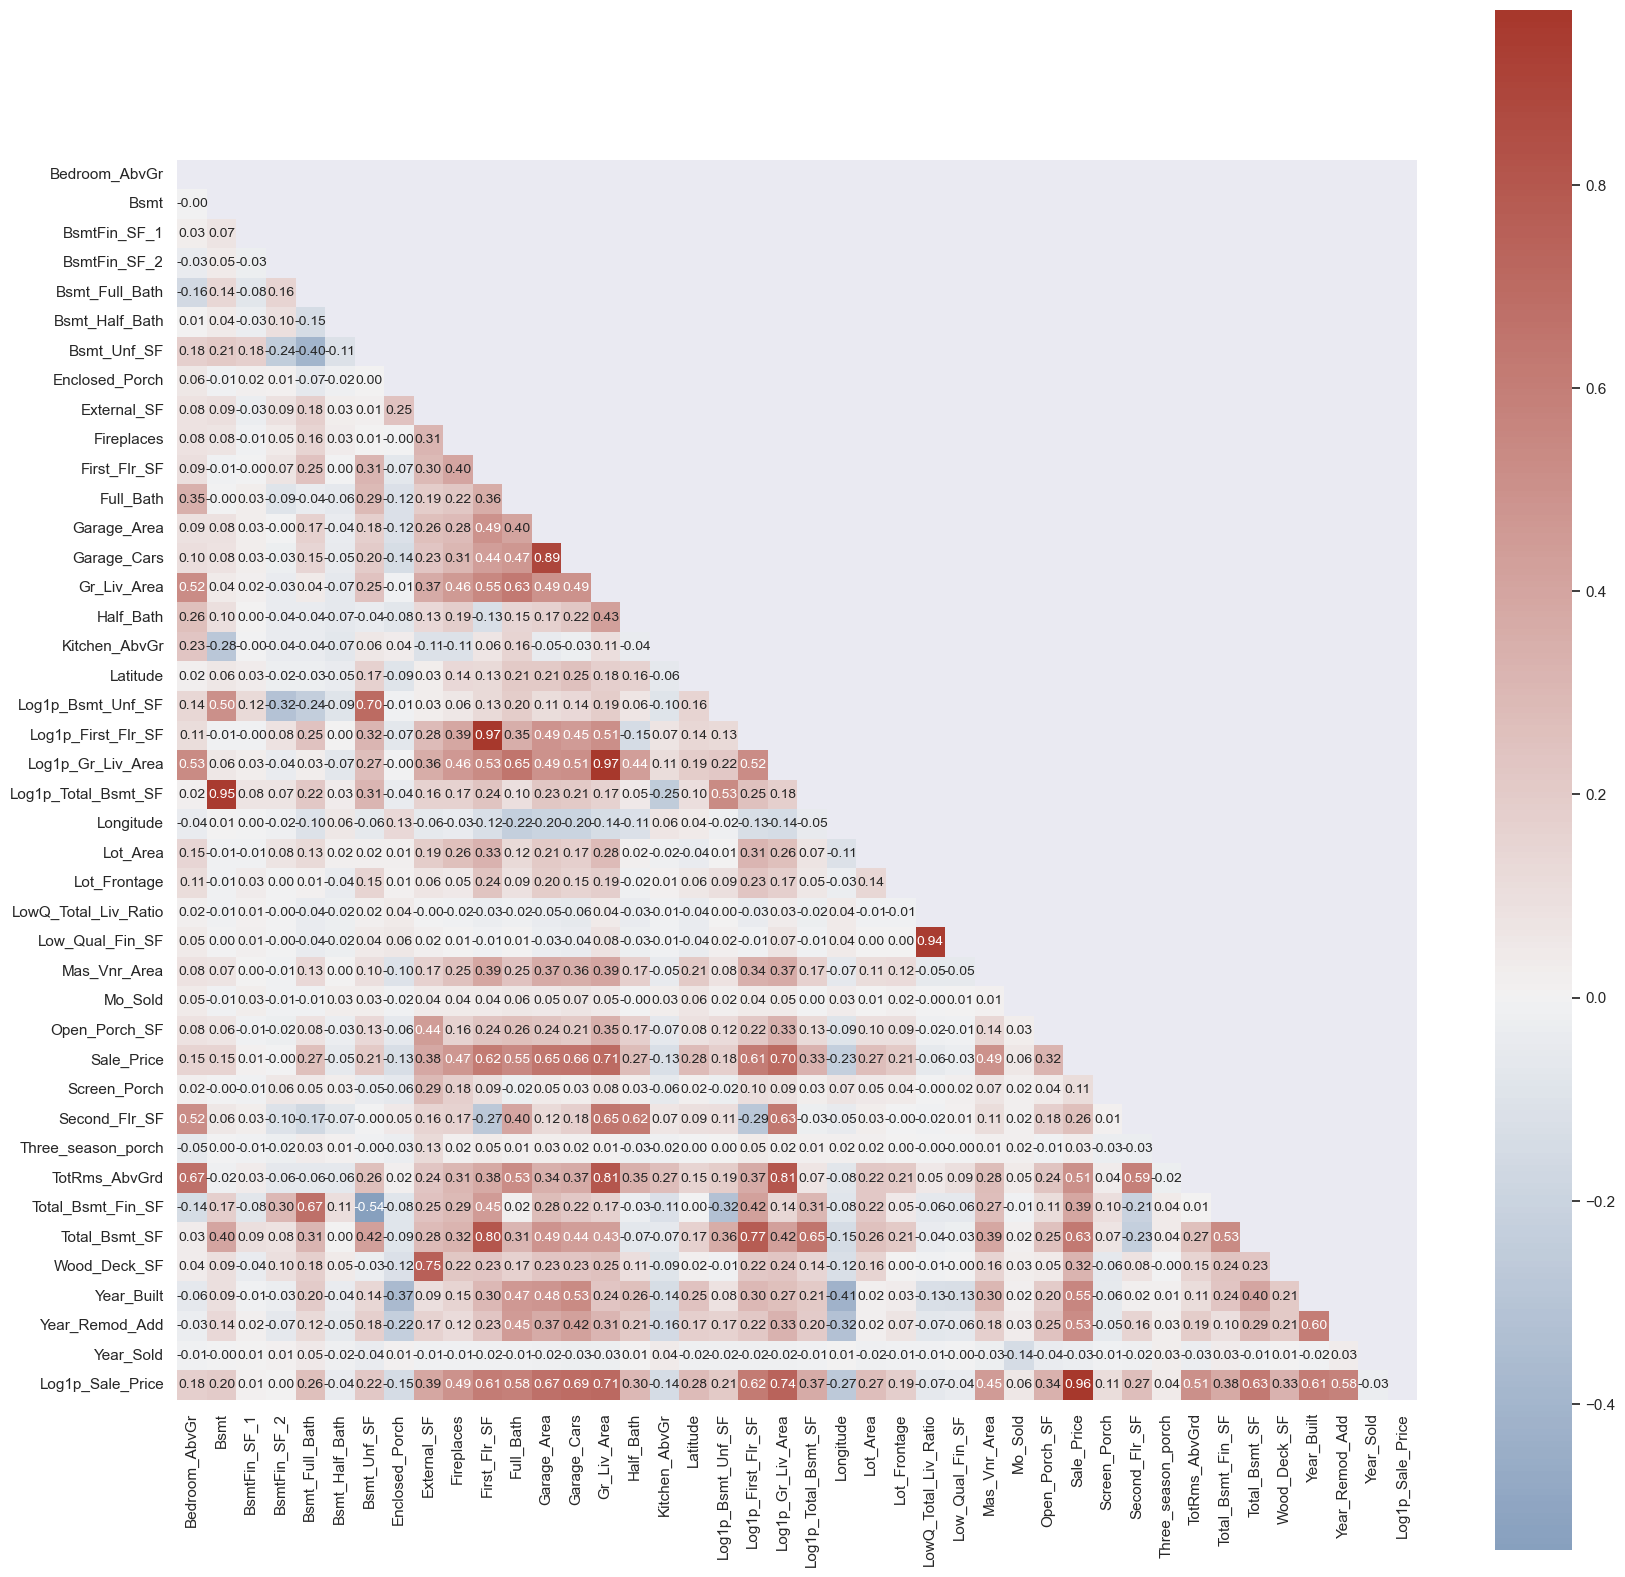

In [43]:
corr_2 = display_corr_matrix(sort_alphabetically(df, 'Log1p_Sale_Price'), label='Log1p_Sale_Price')

In [44]:
top_corr_dict_2 = top_correlated_features(corr, 'Log1p_Sale_Price', 0.40)
top_corr_dict_2

{'Sale_Price': 0.9635749582391173,
 'Log1p_Gr_Liv_Area': 0.7364580645364008,
 'Gr_Liv_Area': 0.7109740196551924,
 'Garage_Cars': 0.6888724434090898,
 'Garage_Area': 0.6719465717827469,
 'Total_Bsmt_SF': 0.6275708869561005,
 'Log1p_First_Flr_SF': 0.6201814442244927,
 'Year_Built': 0.6103489340444651,
 'First_Flr_SF': 0.6094090673705478,
 'Full_Bath': 0.5834714782326151,
 'Year_Remod_Add': 0.577949101586565,
 'TotRms_AbvGrd': 0.5074436853113983,
 'Fireplaces': 0.4928754743869062,
 'Mas_Vnr_Area': 0.44944457869715204}

Let us see what are the top correlated features for both `Sale_Price`

In [45]:
print("The most correlated features with Sale_Price are: \n")
for k in top_corr_dict:
    if 'Log1p' in k: continue
    if k in top_corr_dict_2: print(k)

The most correlated features with Sale_Price are: 

Gr_Liv_Area
Garage_Cars
Garage_Area
Total_Bsmt_SF
First_Flr_SF
Year_Built
Full_Bath
Year_Remod_Add
TotRms_AbvGrd
Mas_Vnr_Area
Fireplaces


We must pay attention to the ones who show collinearity as they might disturb our prediction. We should investigate the relationships of high correlation between other variables.

In [46]:
display_correlation(top_corr_dict, exclude=['Sale_Price', 'Log1p_Sale_Price'])

Top correlated features with "Gr_Liv_Area"
	TotRms_AbvGrd : 0.8111743325058652
	Second_Flr_SF : 0.648382632266102
	Full_Bath : 0.625990856713263


Top correlated features with "Log1p_Gr_Liv_Area"
	Gr_Liv_Area : 0.9722117774723
	TotRms_AbvGrd : 0.8050825632223824
	Full_Bath : 0.649925549645592
	Second_Flr_SF : 0.6311910488540314


Top correlated features with "Garage_Cars"
	Garage_Area : 0.8852691923654916


Top correlated features with "Garage_Area"
	Garage_Cars : 0.8852691923654916


Top correlated features with "Total_Bsmt_SF"
	First_Flr_SF : 0.8009827386811876
	Log1p_First_Flr_SF : 0.7721227765767619


Top correlated features with "First_Flr_SF"
	Total_Bsmt_SF : 0.8009827386811876


Top correlated features with "Log1p_First_Flr_SF"
	First_Flr_SF : 0.9683622622951497
	Total_Bsmt_SF : 0.7721227765767619


Top correlated features with "Year_Built"
	Year_Remod_Add : 0.6038619055459883


Top correlated features with "Full_Bath"
	Log1p_Gr_Liv_Area : 0.649925549645592
	Gr_Liv_Area : 0.6259

Now that we saw what features are highly correlated with Sale_Price, we will take a closer look at them and at their transformations:
* Above-ground-related features
    * `Gr_Liv_Area`
    * `First_Flr_SF` 
    * `Second_Flr_SF`
    * `Fireplaces`
    * `TotRms_AbvGrd`
    * `Bedroom_AbvGr`
    * `Full_Bath`
* Garage-related features
    * `Garage_Cars`
    * `Garage_Area`
* Basement-related features
    * `Total_Bsmt_SF`
* Age-related features
    * `Year_Built`
    * `Year_Remod_Add`
* External-related features
    * `Mas_Vnr_Area`

At the same time we want to confirm that the following ones also matter, since this is what we obtained from domain knowledge research:
* `Lot_Area`
* `Year_Sold` and `Mo_Sold` of Sale
* `Sale_Type` and `Sale_Condition`
* `Neighborhood`

Finally, we shall look at the categorical features too.

In [47]:
def scatterplot_single(dataset, target, label, hue=None):
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

def scatterplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):

    fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 8*plot_cols)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for ax, col in zip(axes, dataset.loc[:, dataset.columns.isin(labels)].columns):
        sns.regplot(data=dataset, x=target, y=col, fit_reg=True, scatter=True, ax=ax)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.2, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.5)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass

## Lot Area vs Sale Price

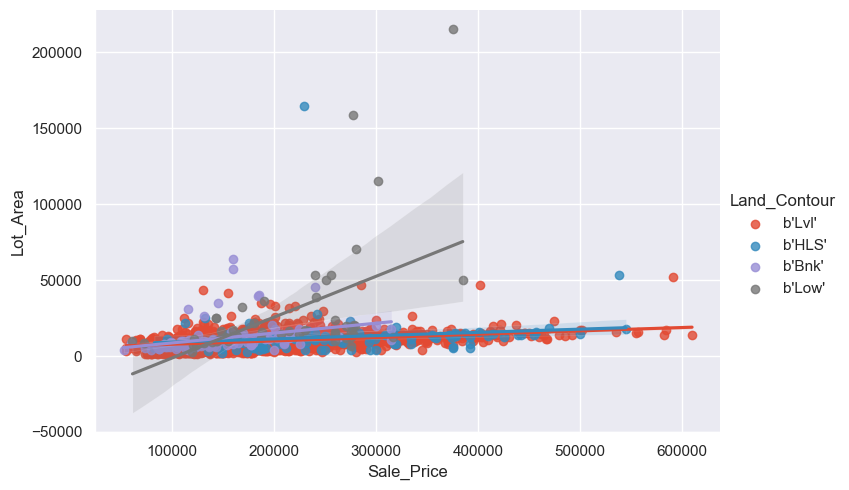

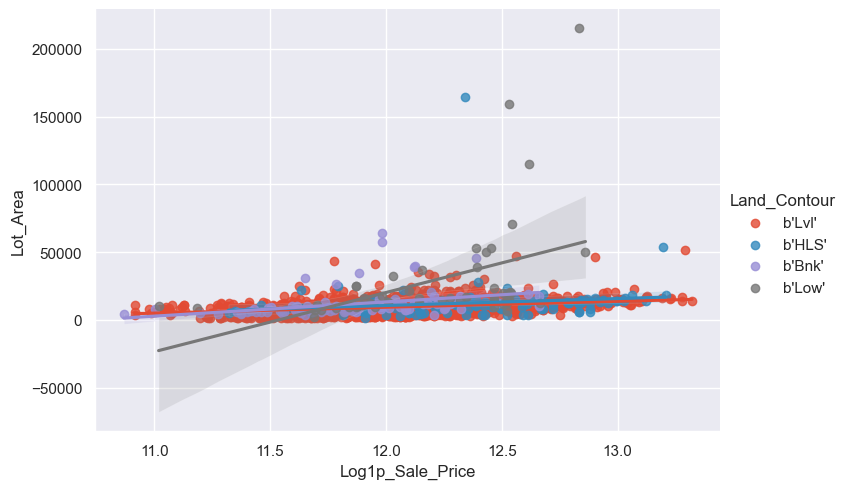

In [48]:
scatterplot_single(df,'Sale_Price', 'Lot_Area', hue='Land_Contour')
scatterplot_single(df,'Log1p_Sale_Price', 'Lot_Area', hue='Land_Contour')

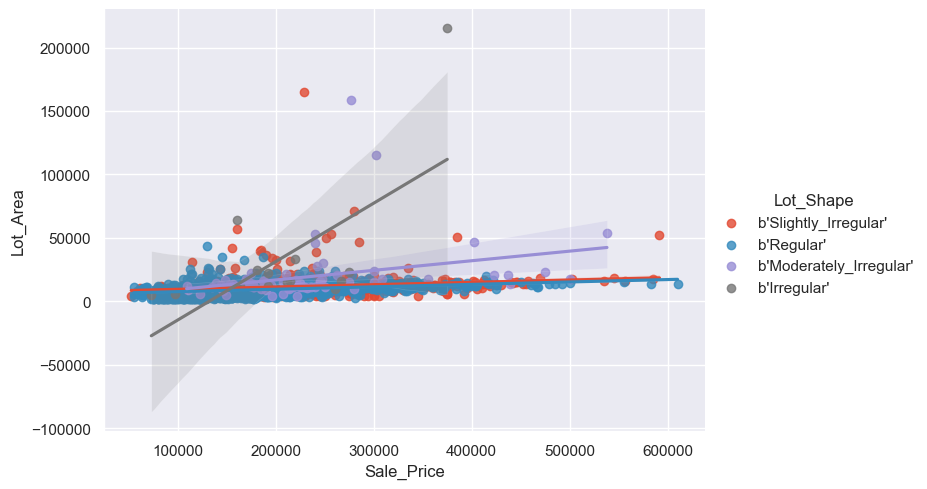

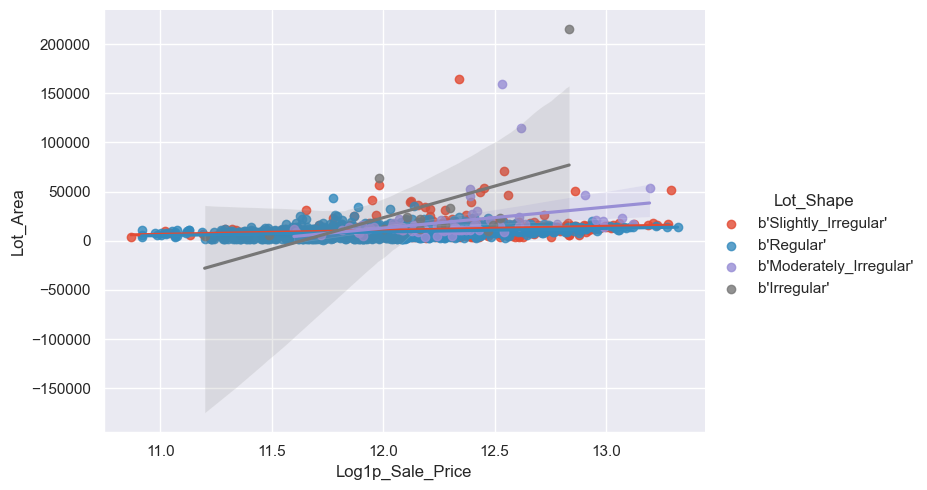

In [49]:
scatterplot_single(df,'Sale_Price', 'Lot_Area', hue='Lot_Shape')
scatterplot_single(df,'Log1p_Sale_Price', 'Lot_Area', hue='Lot_Shape')

We can tell that any property with more than $40000$ square feet of lot area can be seen as an outlier as most instances have an area that is less than $25000$ square feet.  

Plus, it is evident that neither `Lot_Shape` or `Land_Contour` play a big role.

If we wonder why that is the case, is because most houses are old and were never renewed!

In [50]:
df[(df['Lot_Area']>40000) & (df['Year_Built'] <= 1980)][['Lot_Area', 'Year_Built', 'Sale_Price']]

Lot_Area  Year_Built  Sale_Price
287    57200.0      1948.0    160000.0
877   215245.0      1965.0    375000.0
1284   53227.0      1954.0    256000.0
1288   45600.0      1908.0    240000.0
1373   47007.0      1959.0    284700.0
1435  164660.0      1965.0    228950.0
1497   41600.0      1969.0    155000.0
1904  115149.0      1971.0    302000.0
1947  159000.0      1958.0    277000.0
2098   43500.0      1953.0    130000.0
2535   70761.0      1975.0    280000.0
2646   50102.0      1958.0    250764.0

If we analyze just the houses that are relatively new, we find a smalller variance!

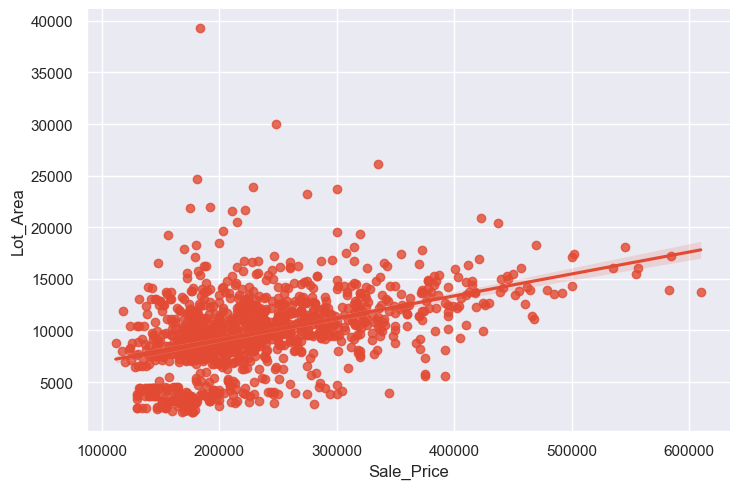

In [51]:
scatterplot_single(df[(df['Lot_Area']<=40000) & (df['Year_Built'] > 1980)],'Sale_Price', 'Lot_Area')

To avoid losing possible information, we drop just those ones over $35000$

In [52]:
df.drop(df[df['Lot_Area']>40000].index.tolist(),axis=0,inplace=True)

## Seasonality related features vs Sale Price

From the description we know the houses were all sold between 2006 and 2010. This means the data might it includes hidden trends of the global state of the economy during the crisis in 2008.

From more research we can recognize the real estate market has seasons which affect the fluctuation of prices, along with the year of sale.

For this reason we can identify the following *seasons*:
1. December-March
2. April-July, which are supposed to be the best months for selling as they provided the highest prices
3. August-November

In [53]:
def seasonality_df(dataset, target, years_col, months_col):
    d = dataset[[target, years_col, months_col]].groupby([years_col, months_col]).describe()
    d.columns = d.columns.droplevel()
    d = d.reset_index()
    return d.drop(columns=['std', '25%', '75%']).rename(columns={'50%':'median'})


def target_by_year_month(dataset, target, highlight):
    d = seasonality_df(dataset=dataset, target=target, years_col='Year_Sold',
                      months_col = 'Mo_Sold')
    
    grid = sns.FacetGrid(d, 
                         col="Year_Sold",
                         palette="tab20c", 
                         col_wrap=5, height=3)

    grid.map(plt.plot, "Mo_Sold", highlight, marker="o")
    
    grid.set(xticks=np.arange(13),
             xlim=(0, 13), 
             xlabel ='Month', ylabel= highlight.capitalize())
    
    grid.fig.tight_layout(w_pad=0.5)
    pass

Here we display the distribution of sales throughout the years to confirm what we have discovered so far.

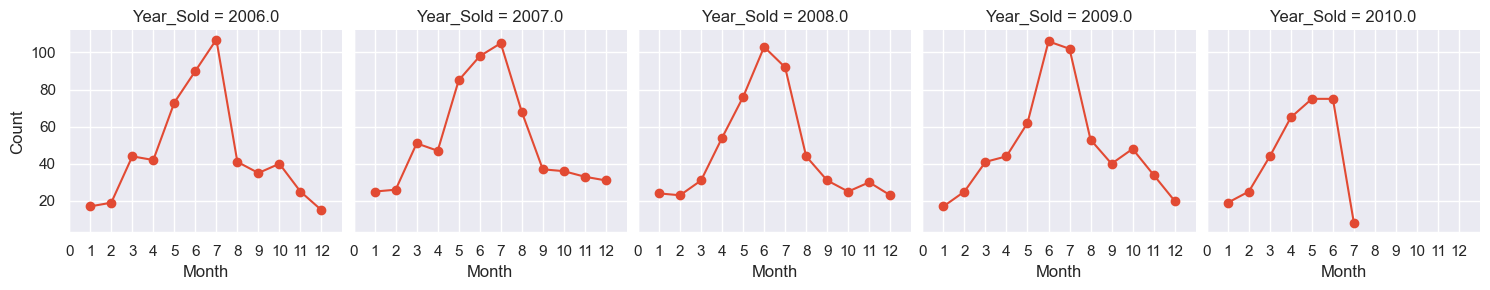

In [54]:
target_by_year_month(df, target='Sale_Price', highlight='count')

As we expected, the central months seem to be the most important ones for selling.

What about the price?

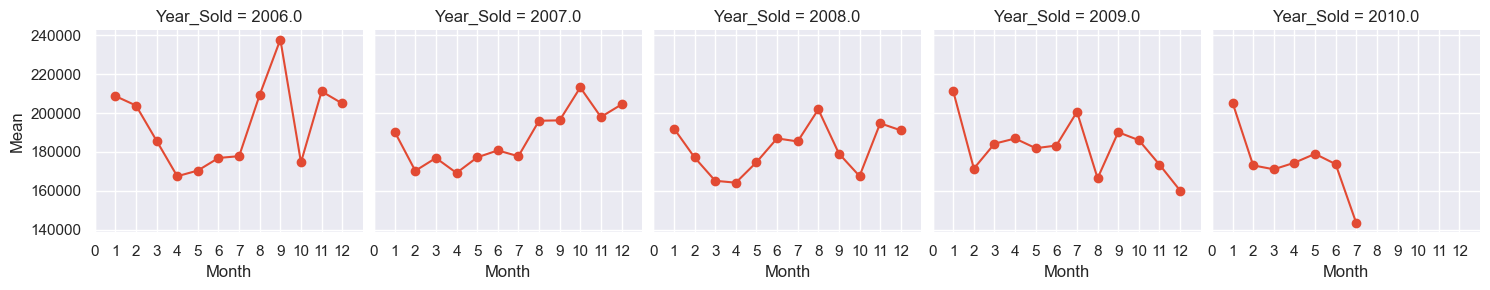

In [55]:
target_by_year_month(df, target='Sale_Price', highlight='mean')

We do see a big drop during 2008 and a negative trend from 2009 to 2010, as we expected.

## Sale related features vs Sale Price

In [56]:
def stripplot_single(dataset, target, categ_feat, figsize=None):
    if figsize is None:
        fig, ax = plt.subplots(figsize=(11,7))
    else:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(y=categ_feat, x=target, data =dataset, jitter = True, dodge = True, ax=ax)
    pass

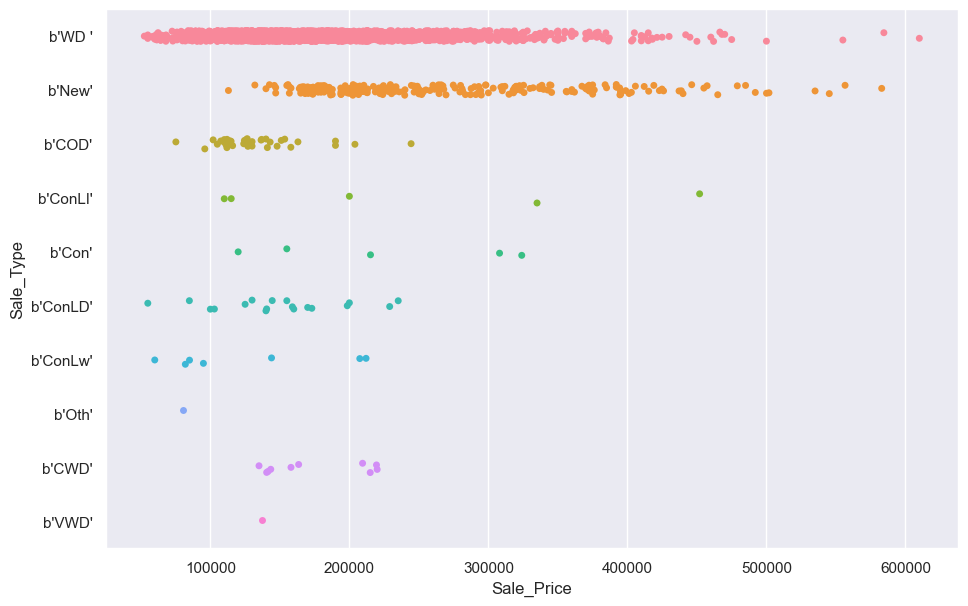

In [57]:
stripplot_single(dataset=df, categ_feat ='Sale_Type', target ='Sale_Price')

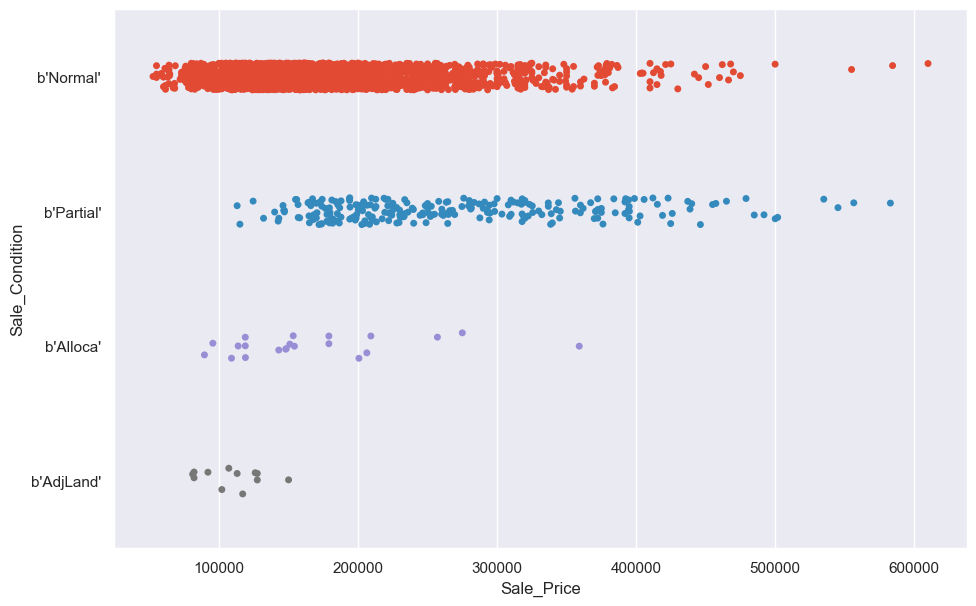

In [58]:
stripplot_single(dataset=df, categ_feat ='Sale_Condition', target ='Sale_Price')

These feature do not really show much but can still be used!

## Location related features vs Sale Price

Even though we have decided to omit it, it is still interesting to show `MS_SubClass` and its impact on `Sale_Price`

In [59]:
def quick_categ_binning(dataset, target:str, name_like:str, bins:list):
    i = 1
    for b in bins:
        dataset[[target]] = dataset[[target]].replace(to_replace=b, value = name_like +str(i))
        i+=1
    pass

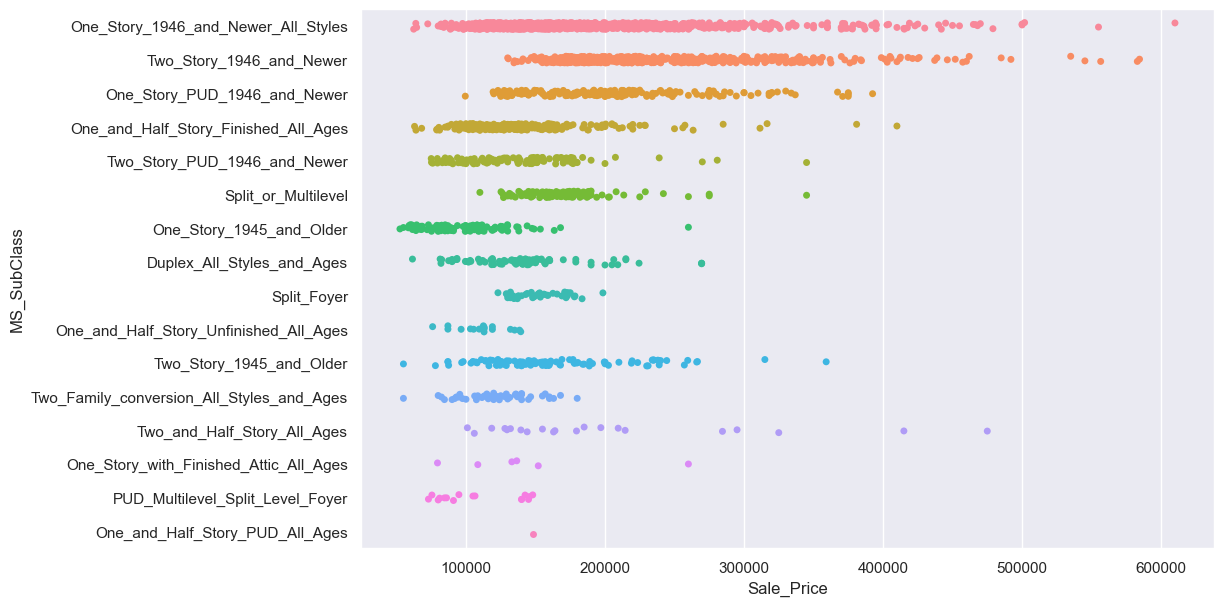

In [60]:
df[['MS_SubClass']] = df[['MS_SubClass']].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))
df_orig[['MS_SubClass']] = df_orig[['MS_SubClass']].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))

stripplot_single(dataset=df, categ_feat ='MS_SubClass', target ='Sale_Price')

In [61]:
sc_block1= ['Two_Story_1946_and_Newer', 'One_Story_PUD_1946_and_Newer']
sc_block2=['One_Story_1946_and_Newer_All_Styles','Two_and_Half_Story_All_Ages']
sc_block3=['One_and_Half_Story_Finished_All_Ages', 'Two_Story_PUD_1946_and_Newer', 
           'Duplex_All_Styles_and_Ages','One_Story_with_Finished_Attic_All_Ages']
sc_block4=['Two_Story_1945_and_Older', 'Two_Family_conversion_All_Styles_and_Ages', 
           'One_and_Half_Story_PUD_All_Ages', 'Two_and_Half_Story_All_Ages',
           'One_Story_with_Finished_Attic_All_Ages']
sc_block5= ['Split_or_Multilevel', 'Split_Foyer']
sc_block6=['One_Story_1945_and_Older', 'PUD_Multilevel_Split_Level_Foyer', 'One_and_Half_Story_Unfinished_All_Ages']

subclass_blocks = [sc_block1, sc_block2, sc_block3,sc_block4,sc_block5, sc_block6]

quick_categ_binning(dataset = df, target= 'MS_SubClass', name_like = 'ms_subclass_', bins = subclass_blocks)
quick_categ_binning(dataset = df_orig, target='MS_SubClass', name_like = 'ms_subclass_', bins = subclass_blocks)

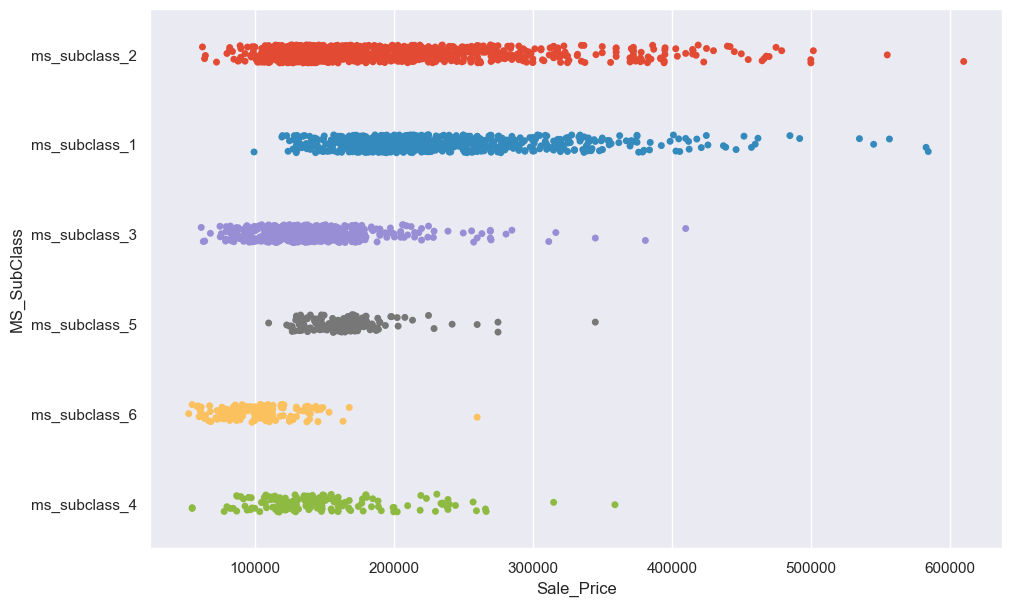

In [62]:
stripplot_single(dataset=df, categ_feat ='MS_SubClass', target ='Sale_Price')

### MS Zoning vs Sale Price

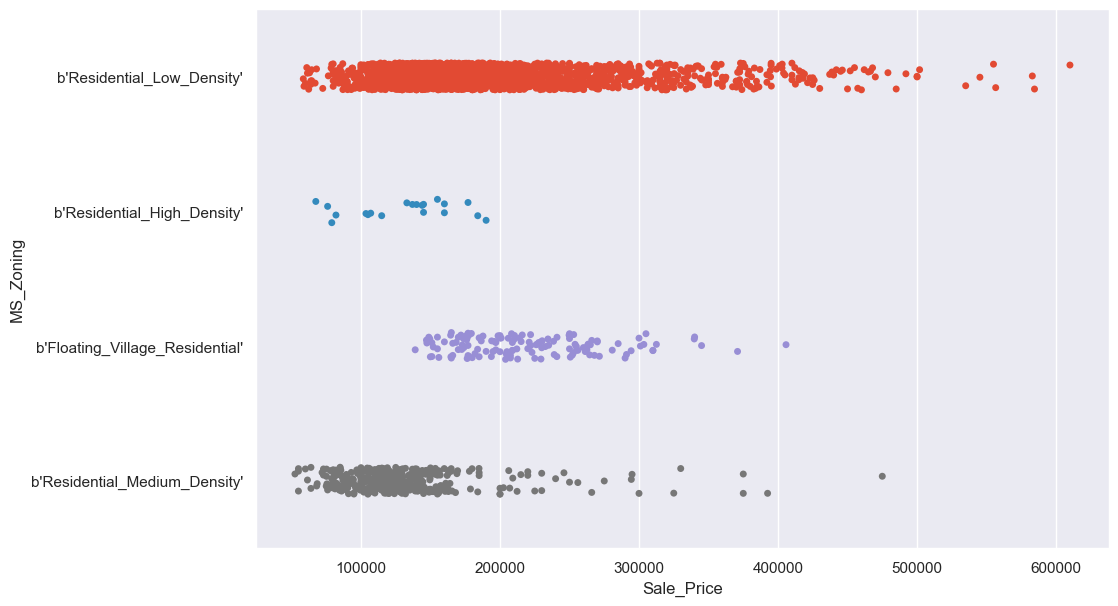

In [63]:
stripplot_single(dataset=df, categ_feat ='MS_Zoning', target ='Sale_Price')

### Neighborhood vs Sale Price

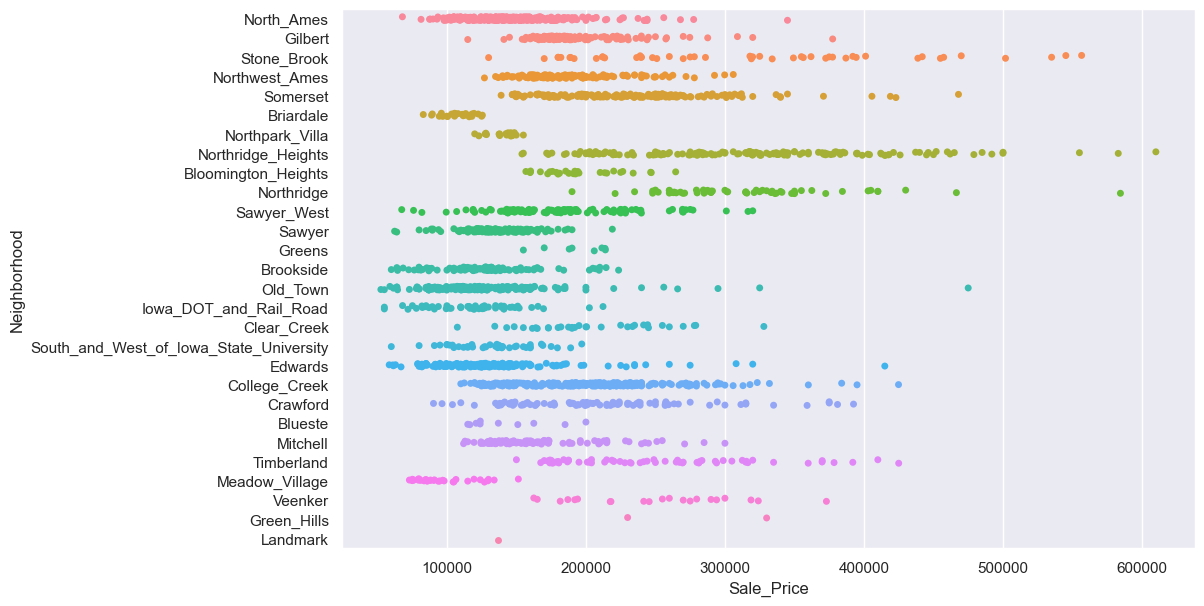

In [64]:
df[['Neighborhood']] = df[['Neighborhood']].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))
df_orig[['Neighborhood']] = df_orig[['Neighborhood']].apply(lambda x: x.str.replace("b'", "").str.replace("'", ""))


stripplot_single(dataset=df, categ_feat ='Neighborhood', target ='Sale_Price')

From this plot we can conclude the neighborhood per-se does not reall help. We might consider fusing them into blocks!

In [65]:
# Based on the graph

block1 = ['North_Ames', 'Sawyer_West', 'Sawyer', 
          'Brookside', 'Old_Town', 'Iowa_DOT_and_Rail_Road',
         'South_and_West_of_Iowa_State_University', 'Edwards', 'Landmark', 
          'Northpark_Villa']
block2 = ['Briardale', 'Meadow_Village']
block3 = ['Gilbert', 'Northwest_Ames', 'Somerset']
block4 = ['College_Creek', 'Crawford', 'Blueste', 
          'Mitchell', 'Veenker', 'Green_Hills', 
          'Timberland']
block5 = ['Greens', 'Clear_Creek', 'Bloomington_Heights']
block6 = ['Northridge_Heights', 'Stone_Brook', 'Northridge']
n_blocks = [block1, block2, block3, block4, block5, block6]

quick_categ_binning(dataset = df, target= 'Neighborhood', name_like = 'neighborhoods_', bins = n_blocks)
quick_categ_binning(dataset = df_orig, target= 'Neighborhood', name_like = 'neighborhoods_', bins = n_blocks)

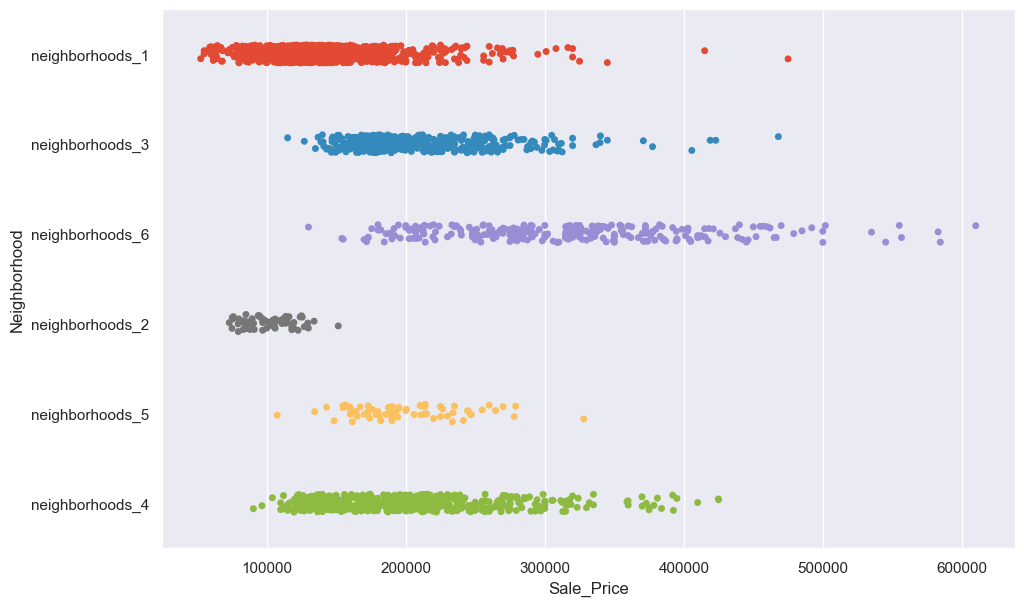

In [66]:
stripplot_single(dataset=df, categ_feat ='Neighborhood', target ='Sale_Price')

---

## Age related features vs Sale Price

As predicted the following features show a high correlation with the price.
* Year_Built
* Year_Remod_Add
* Age

### Year Built vs Sale Price

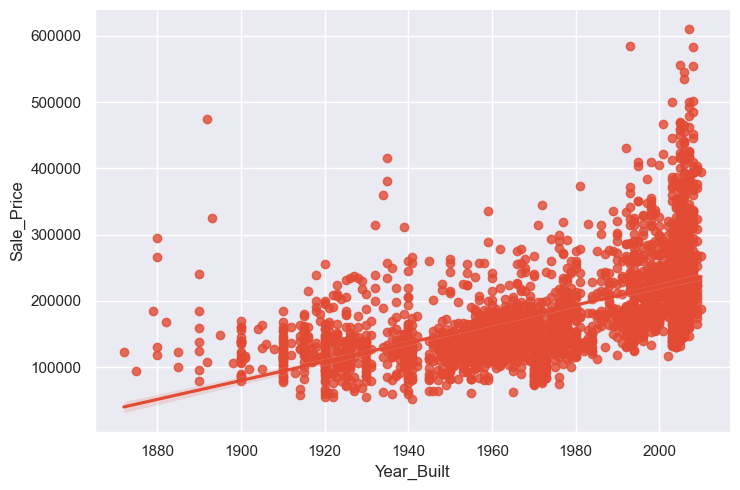

In [67]:
scatterplot_single(df, 'Year_Built', 'Sale_Price')

Until the 2000s we see a steady increase in `Sale_Price`, after that, the price skyrockets which could possibly mean we might need to encode the year of building differently.

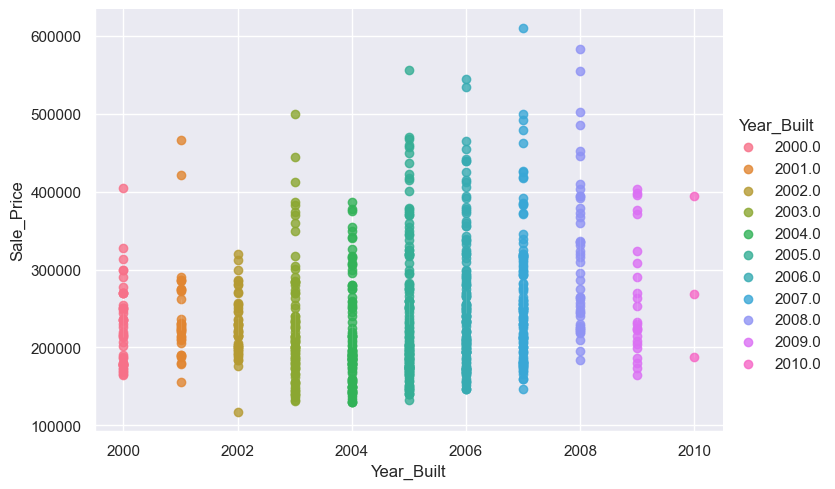

In [68]:
scatterplot_single(df[df['Year_Built'] >= 2000], 'Year_Built', 'Sale_Price', hue='Year_Built')

This graph shows very well how the increase in price stopped in 2008, and started decreasing soon after the crisis.

### Year Remod Add vs Sale Price

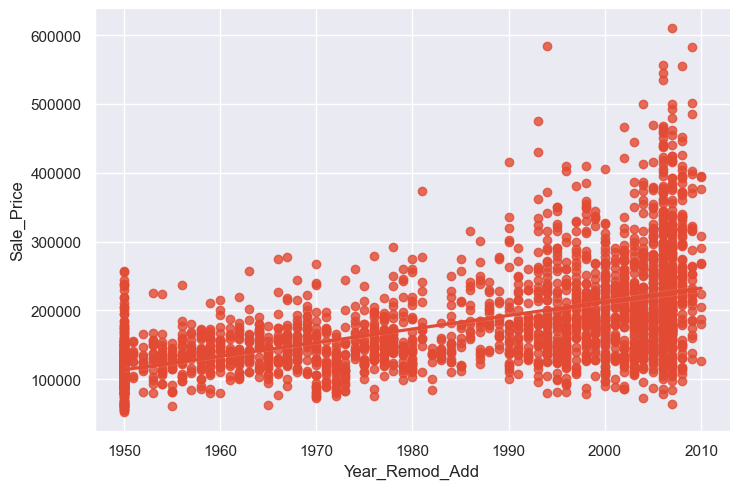

In [69]:
scatterplot_single(df, 'Year_Remod_Add', 'Sale_Price')

From our results we found out that these two features have some correlation between them, let's see how do they change together

### Year Remod Add vs Year Built

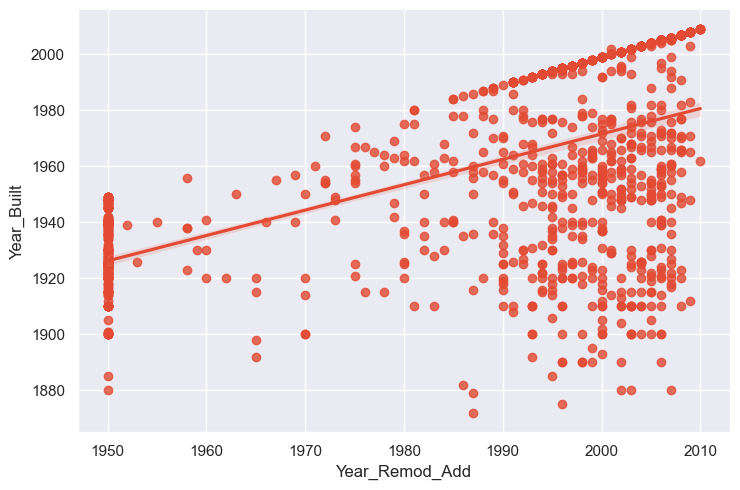

In [70]:
scatterplot_single(df[df['Year_Built']!= df['Year_Remod_Add']], 'Year_Remod_Add', 'Year_Built')

We can see that many houses were never remodeled, as they year of remodeling is the same year the houses were built .

To explore even more the aspect of the age and quality of the buildings we want to find how the aging process contributed to the price.

In [71]:
# Adding structure age variable depending if there was a major remodeling
df['Age'] = df.apply(lambda x: x['Year_Sold']-x['Year_Built'] if (x['Year_Built']<x['Year_Remod_Add'])
                     else (x['Year_Sold']-x['Year_Remod_Add']), axis=1)

df_orig['Age'] = df_orig.apply(lambda x: x['Year_Sold']-x['Year_Built'] if (x['Year_Built']<x['Year_Remod_Add']) 
                               else (x['Year_Sold']-x['Year_Remod_Add']), axis=1)

### Age vs Sale Price

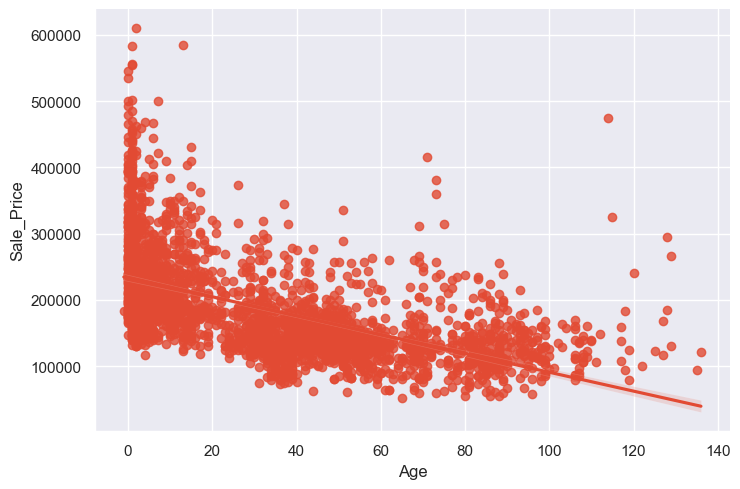

In [72]:
scatterplot_single(df, 'Age', 'Sale_Price')

As we can tell, the relationship is negative as the price decreaseases as time goes by without any remodeling.

The high correlation between these features was a result of the fact that `Year_Remod_Add` takes the same values as `Year_Built` for houses that were never renewed. 

Now we should decide whether to keep just one of the two or to apply other transformations. However an indicator could be useful

In [73]:
df['Remodeled'] = df.apply(lambda x: 0 if (x['Year_Built'] == x['Year_Remod_Add']) 
                                                           else (1), axis=1)

df_orig['Remodeled'] = df_orig.apply(lambda x: 0 if (x['Year_Built'] == x['Year_Remod_Add'])
                                     else (1), axis=1)

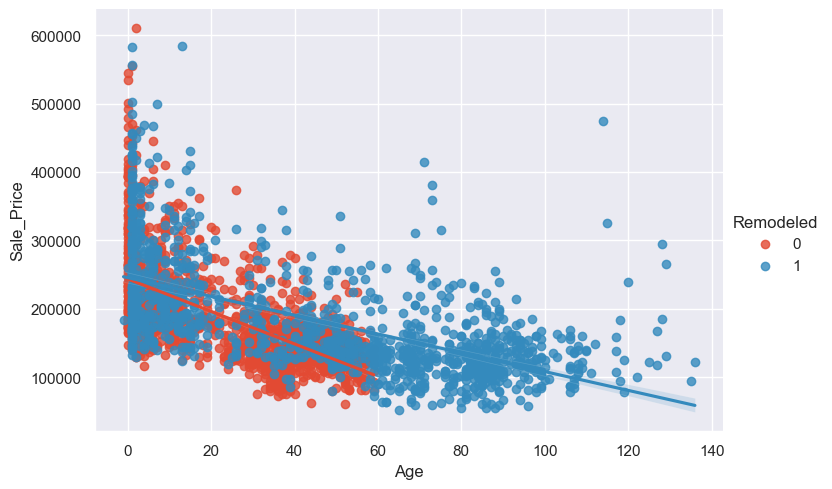

In [74]:
scatterplot_single(df, 'Age', 'Sale_Price', hue='Remodeled')

As predicted, house prices lower faster when the age of the building goes up, but the relationship still shows a lot of variance for price prediction.

---

## Above ground living related features vs Sale Price
* Gr_Liv_Area
* Fireplaces
* Full_Bath
* First_Flr_SF, Second_Flr_SF
* TotRms_AbvGrd

### First Flr SF vs Sale Price

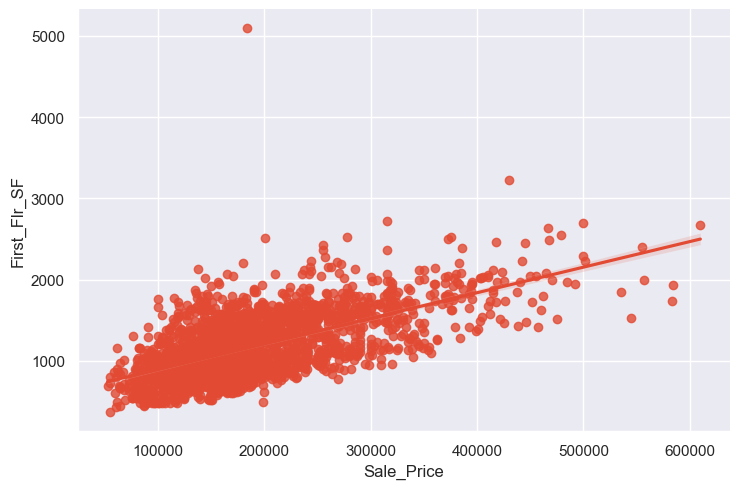

In [75]:
scatterplot_single(df, 'Sale_Price','First_Flr_SF')

The area of the first floor is positively correlated with `Sale_Price` as we expected, and there is not much variance too. To analyze the second floor against the sale price, we want to add an indicator just to see if the presence of 1+ floors affects the price in a different manner.

In [76]:
df['Flr_AbvGrd'] = df.apply(lambda x: 1 if(x['Second_Flr_SF']>0.0) else 2,axis=1)
df_orig['Flr_AbvGrd'] = df_orig.apply(lambda x: 1 if(x['Second_Flr_SF']>0.0) else 2,axis=1)

### Second Flr SF vs Sale Price

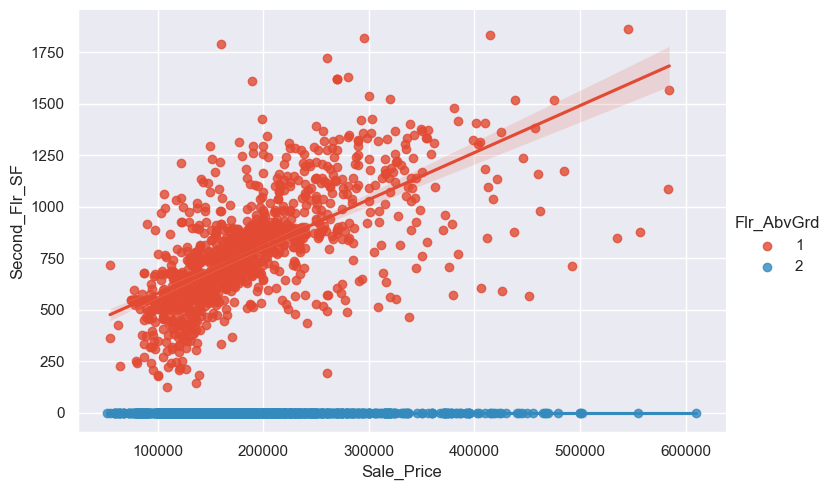

In [77]:
scatterplot_single(df, 'Sale_Price','Second_Flr_SF', hue='Flr_AbvGrd')

We can definitely see a change in the linear prediction when the price is affected by the presence of a second floor.

### Gr Liv Area vs Sale Price

Considering the total area above ground might be better, along with the indicator for a second floor

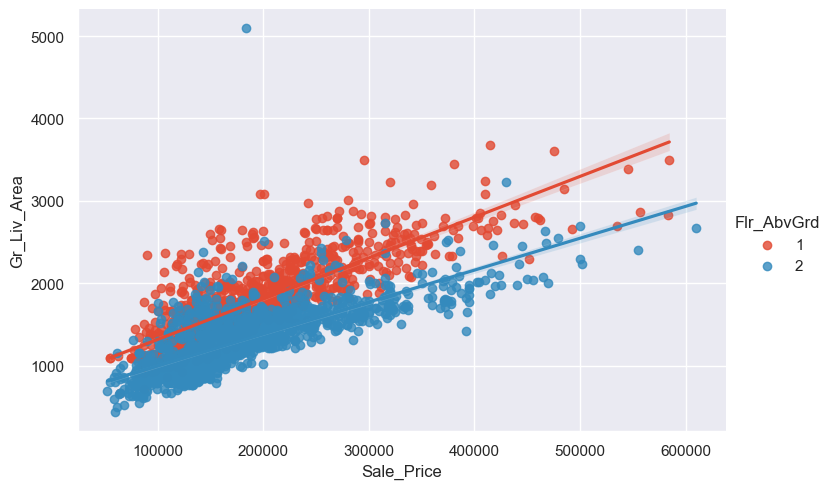

In [78]:
scatterplot_single(df, 'Sale_Price','Gr_Liv_Area', hue='Flr_AbvGrd')

Well that does not seem to have the effect we expected. Let's check the rooms:

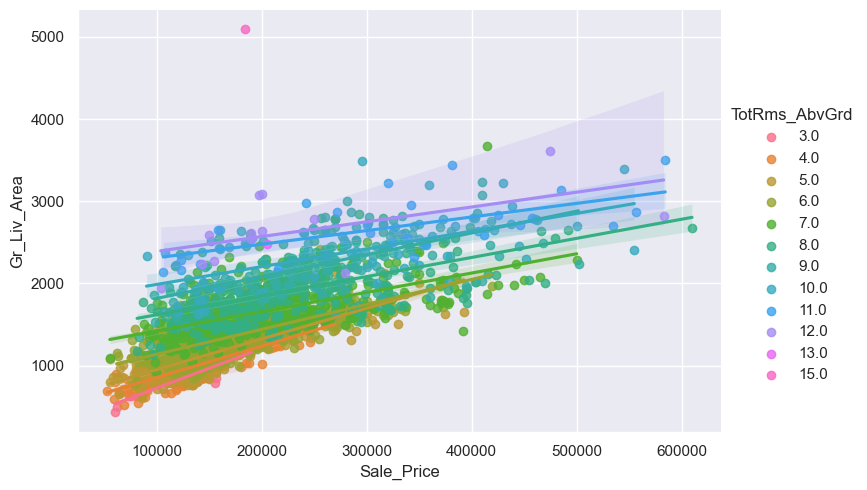

In [79]:
scatterplot_single(df, 'Sale_Price','Gr_Liv_Area', hue='TotRms_AbvGrd')

There sure is a positive relationship between these two features which is also highly affected by the number of rooms above ground each houses has. By removing the outliers, the correlation increases.

### Tot Rms Abv Grd vs Sale Price

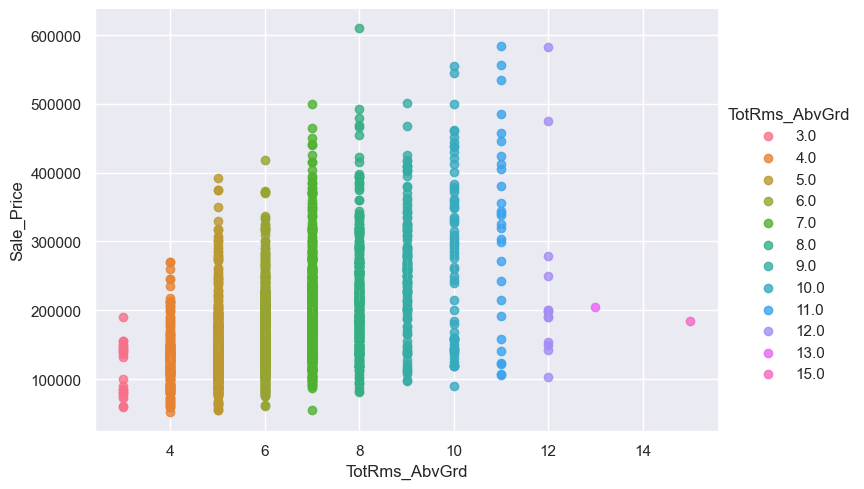

In [80]:
scatterplot_single(df, 'TotRms_AbvGrd','Sale_Price', hue='TotRms_AbvGrd')

For the houses that have 12 to 15 rooms above ground there is not a good representation, so we can say it's best to drop them.

In [81]:
df.drop(df[(df['TotRms_AbvGrd']>=13.0)].index.tolist(), inplace=True)

### Tot Rms Abv Grd vs Gr Liv Area

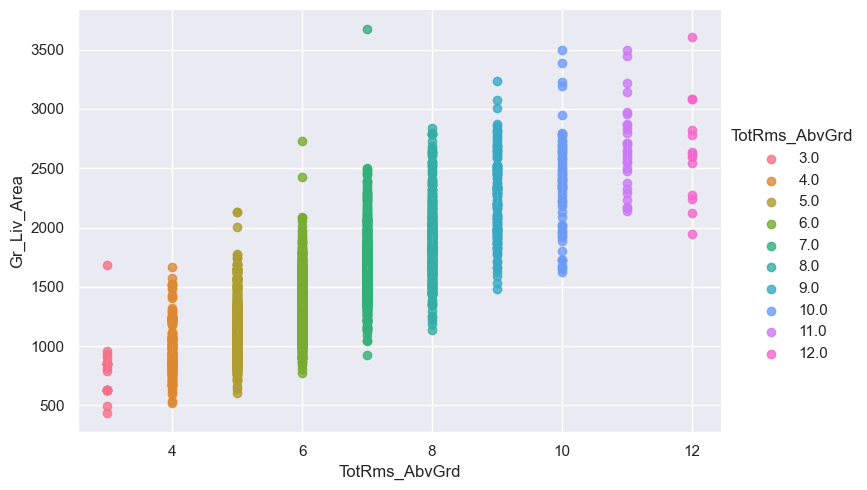

In [82]:
scatterplot_single(df, 'TotRms_AbvGrd','Gr_Liv_Area', hue='TotRms_AbvGrd')

We still see some outliers for the houses with 3 and 7 rooms

In [83]:
df.drop(df[(df['Gr_Liv_Area']>1500)&(df['TotRms_AbvGrd']==3)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>3000)&(df['TotRms_AbvGrd']==7)].index.tolist(), inplace=True)

### Rms Gr Area Ratio vs Sale Price

In [84]:
df['Rms_Gr_Area_Ratio']= df['TotRms_AbvGrd']/df['Gr_Liv_Area']
df_orig['Rms_Gr_Area_Ratio']= df_orig['TotRms_AbvGrd']/df_orig['Gr_Liv_Area']

In [85]:
df['Gr_Area_Rms_Ratio']= df['Gr_Liv_Area']/df['TotRms_AbvGrd']
df_orig['Gr_Area_Rms_Ratio']= df_orig['Gr_Liv_Area']/df_orig['TotRms_AbvGrd']

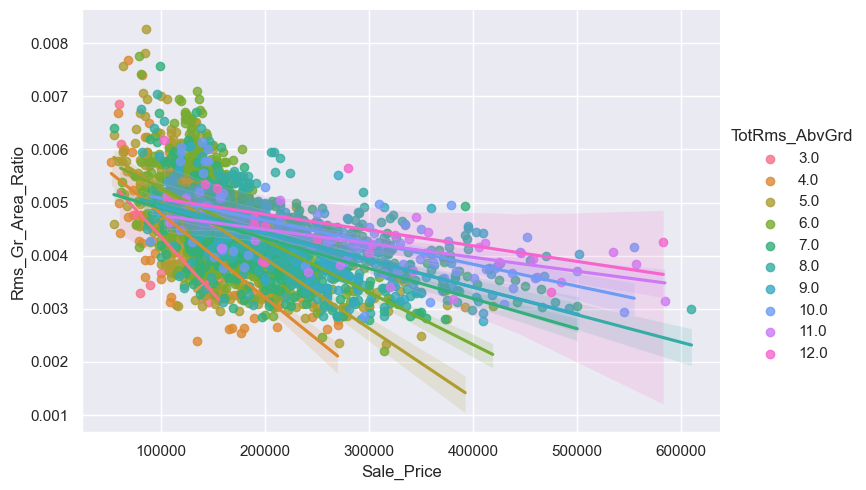

In [86]:
scatterplot_single(df,'Sale_Price', 'Rms_Gr_Area_Ratio', hue='TotRms_AbvGrd')

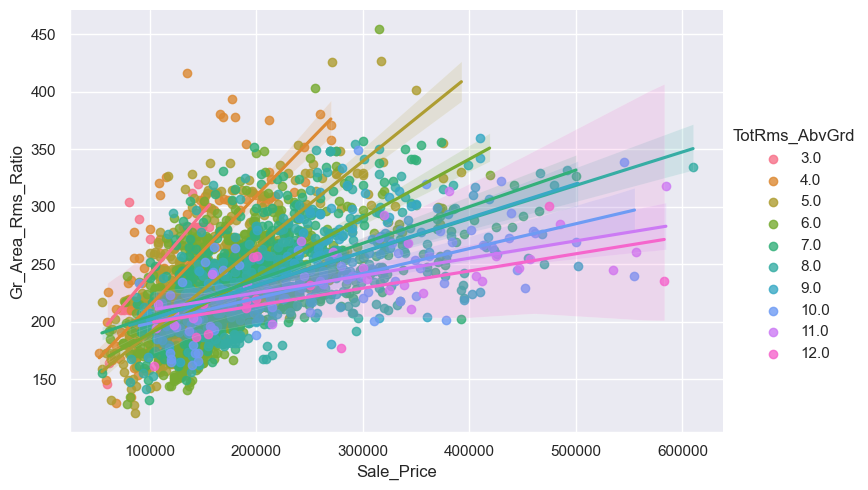

In [87]:
scatterplot_single(df,'Sale_Price', 'Gr_Area_Rms_Ratio', hue='TotRms_AbvGrd')

As we consider more and more variables the instances start becoming very close and we do not get any good insight

### Full bath vs Sale Price

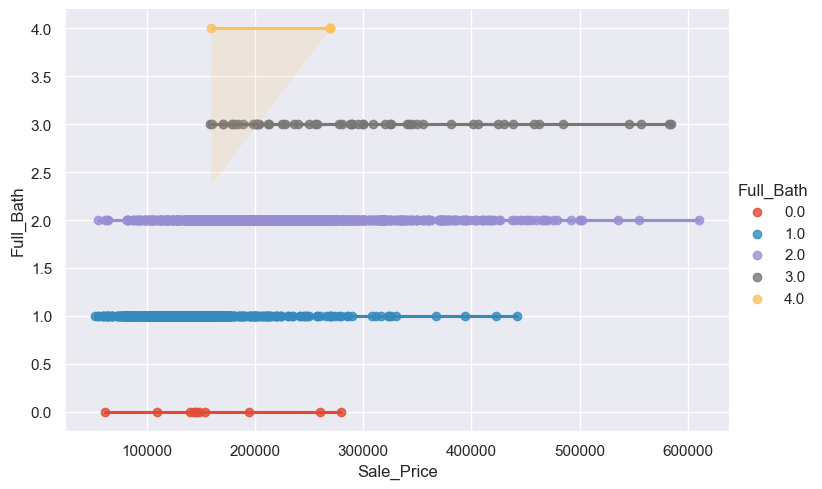

In [88]:
scatterplot_single(df,'Sale_Price', 'Full_Bath', hue='Full_Bath')

### Half bath vs Sale Price

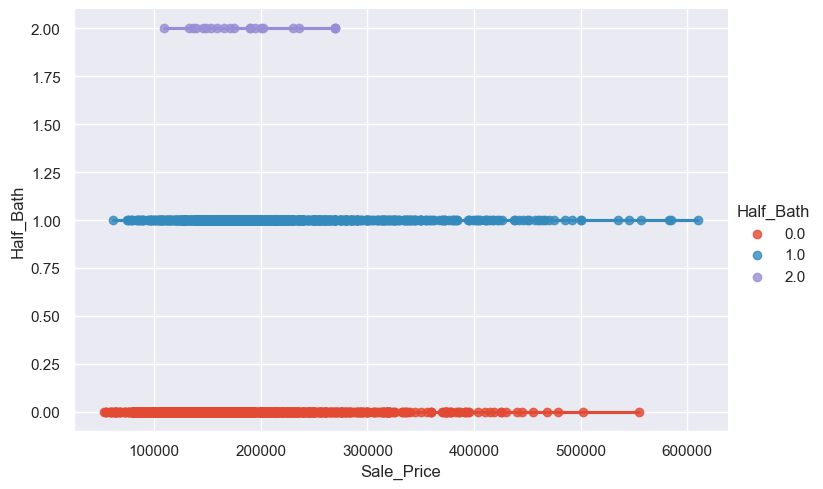

In [89]:
scatterplot_single(df,'Sale_Price', 'Half_Bath', hue='Half_Bath')

### Total bath vs Sale Price

In [90]:
df['Total_Bath'] = df['Full_Bath'] + (df['Half_Bath'] * 0.5)
df_orig['Total_Bath'] = df_orig['Full_Bath'] + (df_orig['Half_Bath'] * 0.5)

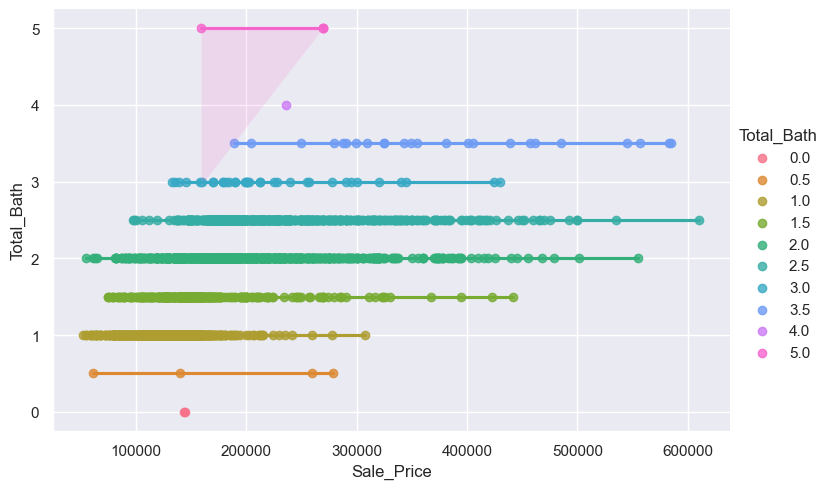

In [91]:
scatterplot_single(df,'Sale_Price', 'Total_Bath', hue='Total_Bath')

### Full bath vs Gr Liv Area

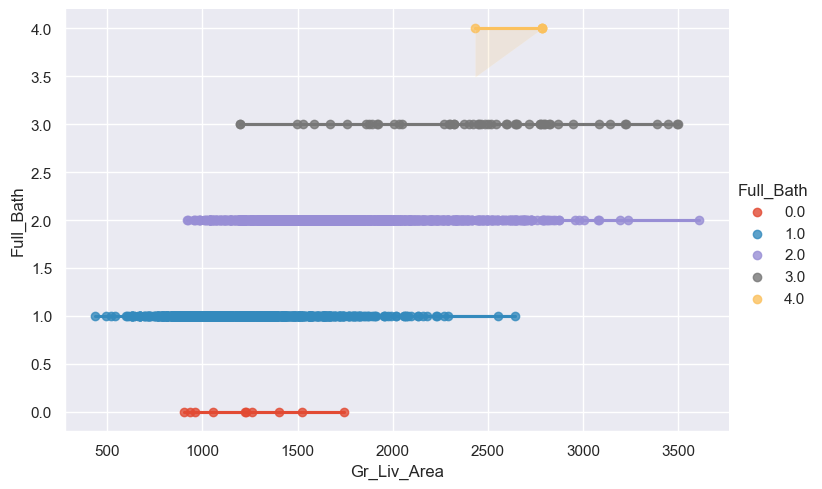

In [92]:
scatterplot_single(df,'Gr_Liv_Area', 'Full_Bath', hue='Full_Bath')

In [93]:
df['TBath_Gr_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Total_Bath'] if(x['Total_Bath']!=0.0) else 0.0, axis=1)
df_orig['TBath_Gr_Area_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Total_Bath'] if(x['Total_Bath']!=0.0) else 0.0, axis=1)

### TBath_Gr_Area_Ratio vs Sale Price

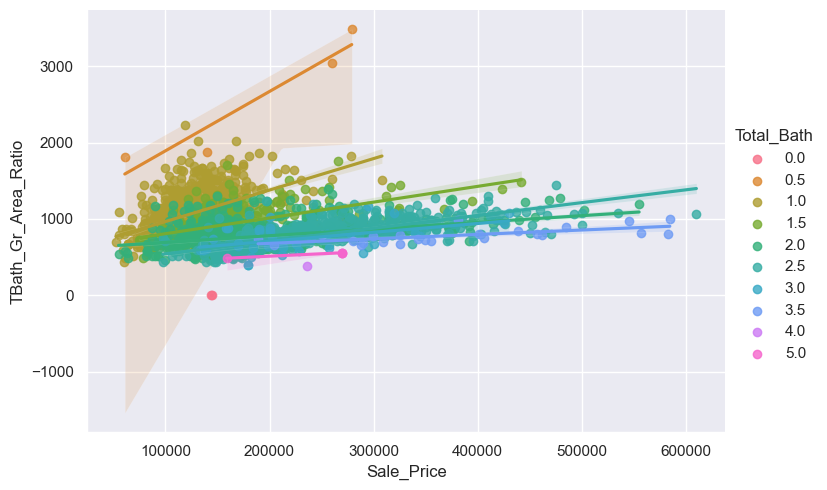

In [94]:
scatterplot_single(df,'Sale_Price', 'TBath_Gr_Area_Ratio', hue='Total_Bath')

### Bedrooms vs Sale Price

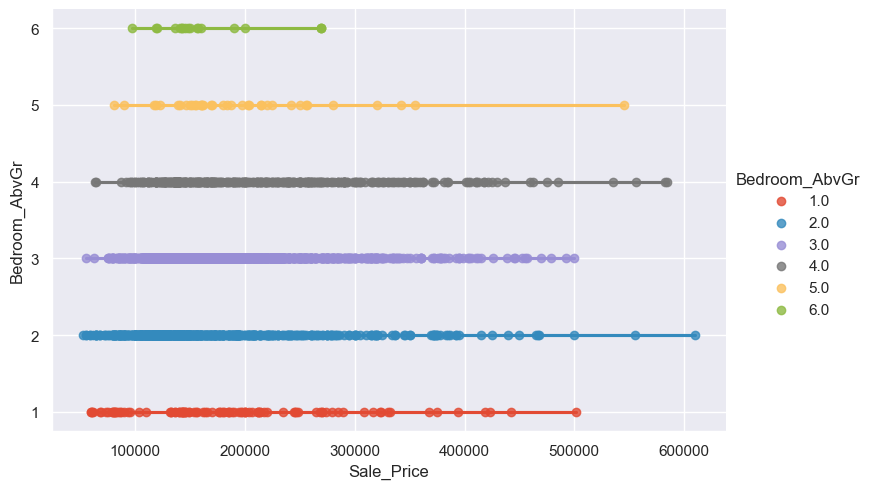

In [95]:
scatterplot_single(df, 'Sale_Price','Bedroom_AbvGr', hue='Bedroom_AbvGr')

### Bedrooms vs Gr Liv Area

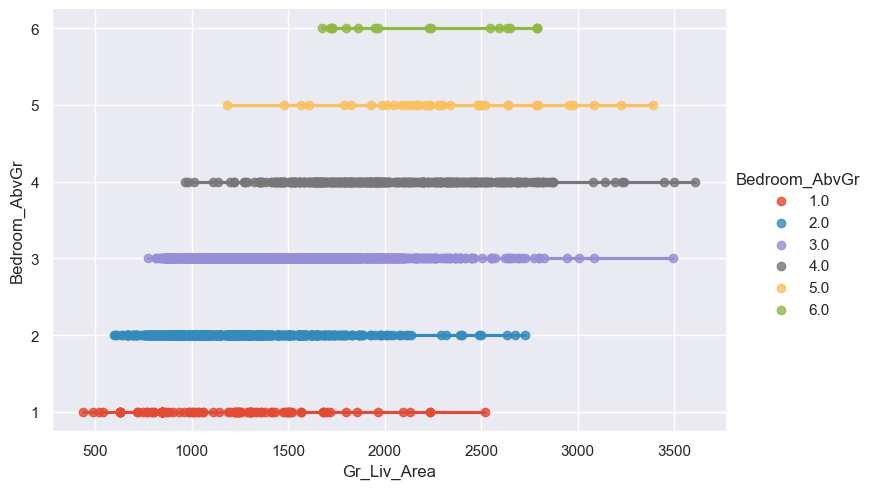

In [96]:
scatterplot_single(df, 'Gr_Liv_Area','Bedroom_AbvGr', hue='Bedroom_AbvGr')

In [97]:
df['Bedroom_Liv_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Bedroom_AbvGr'] if(x['Bedroom_AbvGr']!=0.0) else 0.0, axis=1)
df_orig['Bedroom_Liv_Area_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Bedroom_AbvGr'] if(x['Bedroom_AbvGr']!=0.0) else 0.0, axis=1)

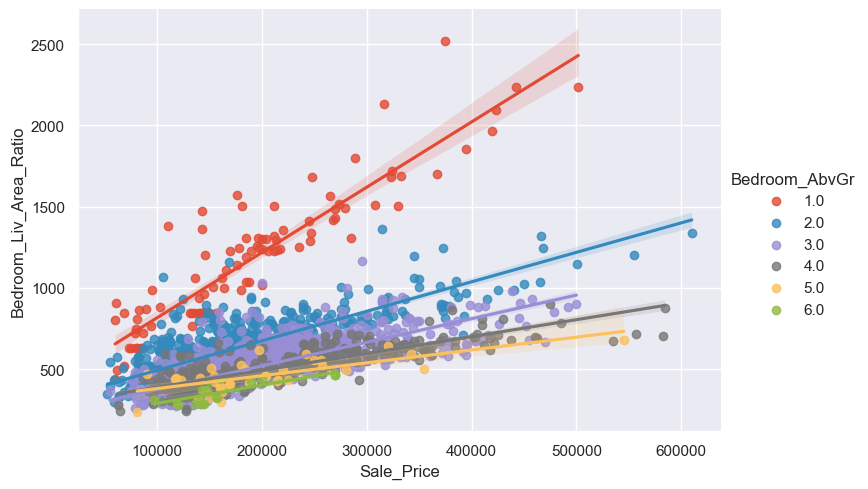

In [98]:
scatterplot_single(df, 'Sale_Price','Bedroom_Liv_Area_Ratio', hue='Bedroom_AbvGr')

### Fireplace vs Sale Price

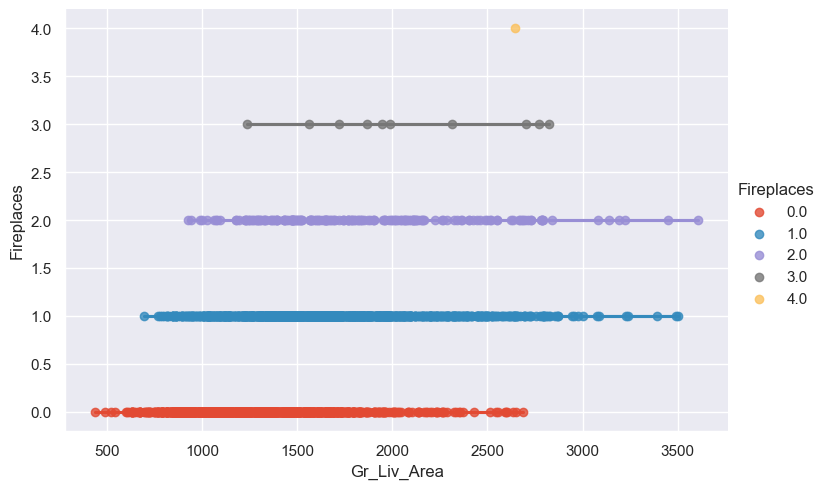

In [99]:
scatterplot_single(df,'Gr_Liv_Area', 'Fireplaces', hue='Fireplaces')

In [100]:
df['Fireplace_Gr_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Fireplaces'] if(x['Fireplaces']!=0.0) else 0.0, axis=1)
df_orig['Fireplace_Gr_Area_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Fireplaces'] if(x['Fireplaces']!=0.0) else 0.0, axis=1)

### Fireplace Gr_Area Ratio vs Sale Price

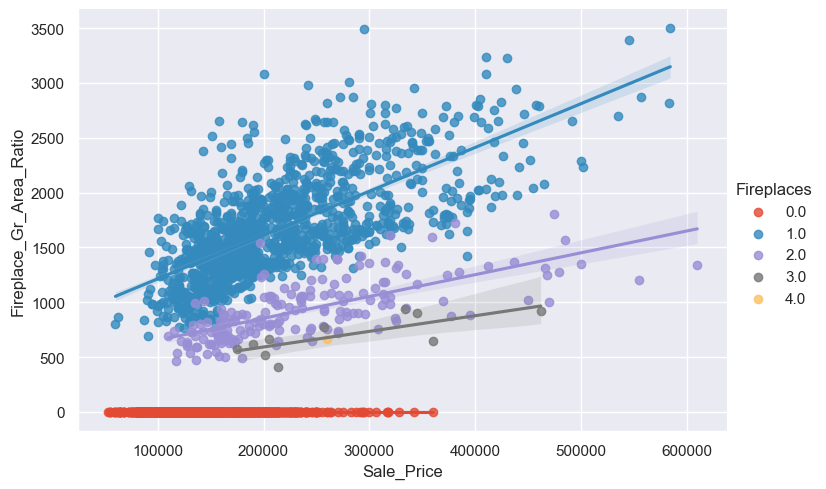

In [101]:
scatterplot_single(df,'Sale_Price', 'Fireplace_Gr_Area_Ratio', hue='Fireplaces')

## Garage related features vs Sale Price
* Garage_Cars
* Garage_Area
* Garage_Cond
* Garage_Qual
* Garage_Type
* Garage_Finish

### Garage Area vs Sale Price

As we can predict, there will be instances without any garage. Let us add another indicator.

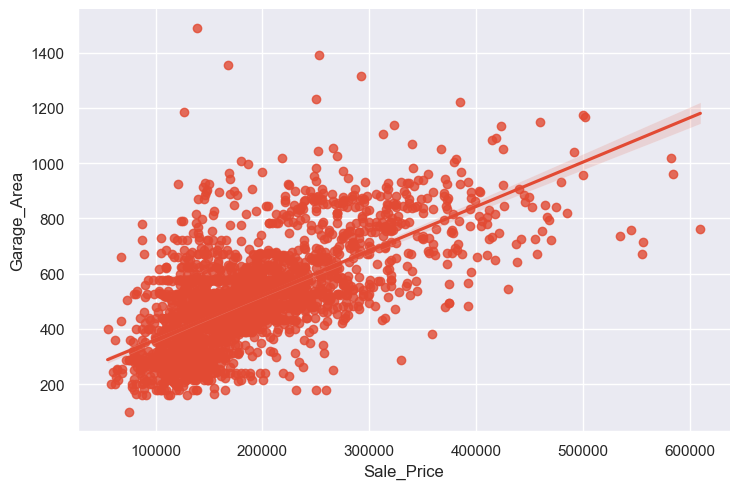

In [102]:
scatterplot_single(df[df['Garage_Area']>0.0], target='Sale_Price', label='Garage_Area')

In [103]:
df[(df['Garage_Area'] > 0.0) & (df['Garage_Type'] == b'No_Garage')]

Empty DataFrame
Columns: [Bedroom_AbvGr, Bldg_Type, Bsmt, BsmtFin_SF_1, BsmtFin_SF_2, BsmtFin_Type_1, BsmtFin_Type_2, Bsmt_Cond, Bsmt_Exposure, Bsmt_Full_Bath, Bsmt_Half_Bath, Bsmt_Qual, Bsmt_Unf_SF, Central_Air, Enclosed_Porch, Exter_Cond, Exter_Qual, Exterior_1st, Exterior_2nd, External_SF, Fence, Fireplace_Qu, Fireplaces, First_Flr_SF, Foundation, Full_Bath, Garage_Area, Garage_Cars, Garage_Cond, Garage_Finish, Garage_Qual, Garage_Type, Gr_Liv_Area, Half_Bath, Heating_QC, House_Style, Kitchen_AbvGr, Kitchen_Qual, Land_Contour, Latitude, Longitude, Lot_Area, Lot_Config, Lot_Frontage, Lot_Shape, LowQ_Total_Liv_Ratio, Low_Qual_Fin_SF, MS_SubClass, MS_Zoning, Mas_Vnr_Area, Mas_Vnr_Type, Mo_Sold, Neighborhood, Open_Porch_SF, Overall_Cond, Overall_Qual, Paved_Drive, Sale_Condition, Sale_Type, Screen_Porch, Second_Flr_SF, Three_season_porch, TotRms_AbvGrd, Total_Bsmt_Fin_SF, Total_Bsmt_SF, Wood_Deck_SF, Year_Built, Year_Remod_Add, Year_Sold, Sale_Price, Log1p_Sale_Price, Log1p_Gr_Liv_Area, Log1p_First_Flr_SF, Log1p_Total_Bsmt_SF, Log1p_Bsmt_Unf_SF, Age, Remodeled, Flr_AbvGrd, Rms_Gr_Area_Ratio, Gr_Area_Rms_Ratio, Total_Bath, TBath_Gr_Area_Ratio, Bedroom_Liv_Area_Ratio, Fireplace_Gr_Area_Ratio]
Index: []

[0 rows x 84 columns]

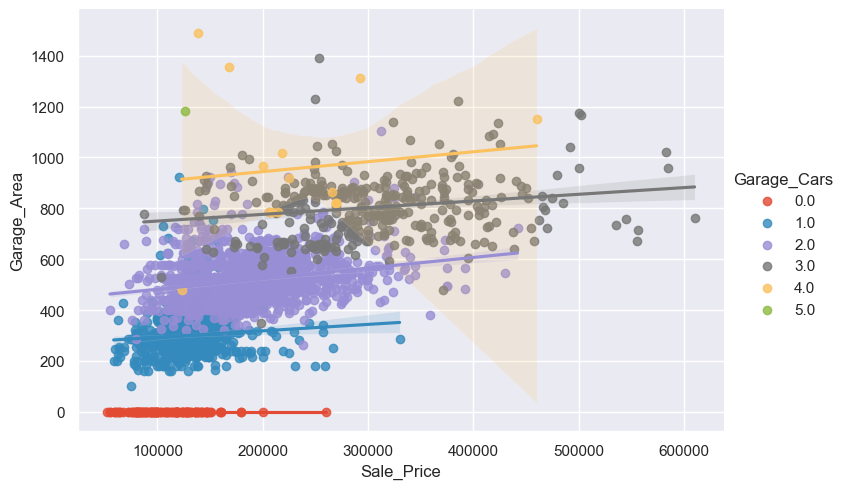

In [104]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage_Cars')

This looks like an outlier for sure, just by looking at the prices we can see there is an increasing trend for prices! 

In [105]:
df.drop(df.loc[df['Garage_Cars']>=5].index.tolist(), inplace=True)
df.drop(df.loc[df['Garage_Area']>1200].index.tolist(), inplace=True)

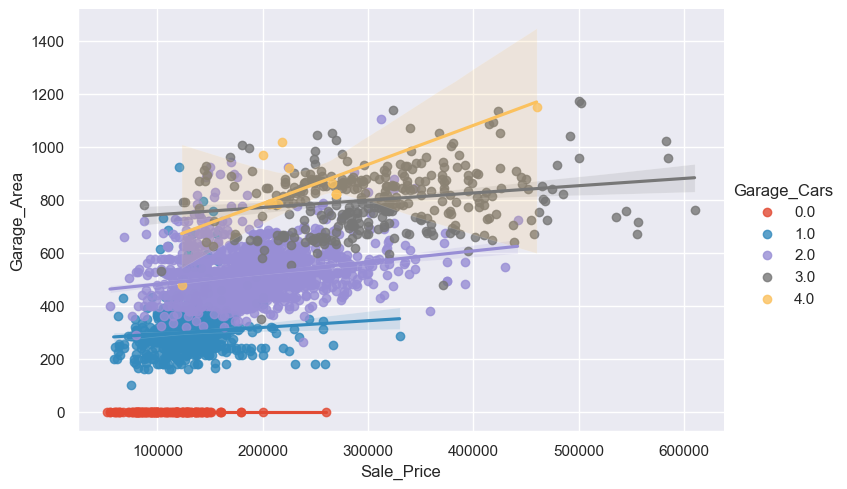

In [106]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage_Cars')

Well they seem to show different behavior for each different count of cars. Let us try and inspect the garage related features in depth

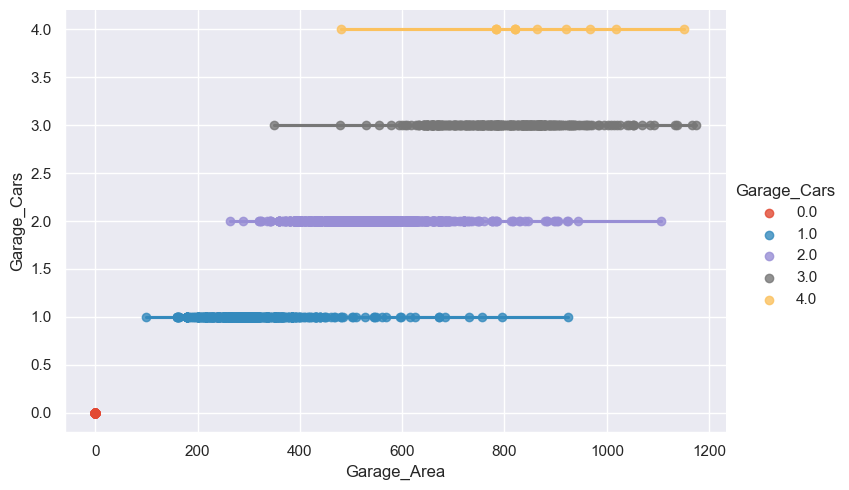

In [107]:
scatterplot_single(df, target='Garage_Area', label='Garage_Cars', hue='Garage_Cars')

It is interesting to see that there seems to be a good correlation between these two features. Let's add this inside our dataframe

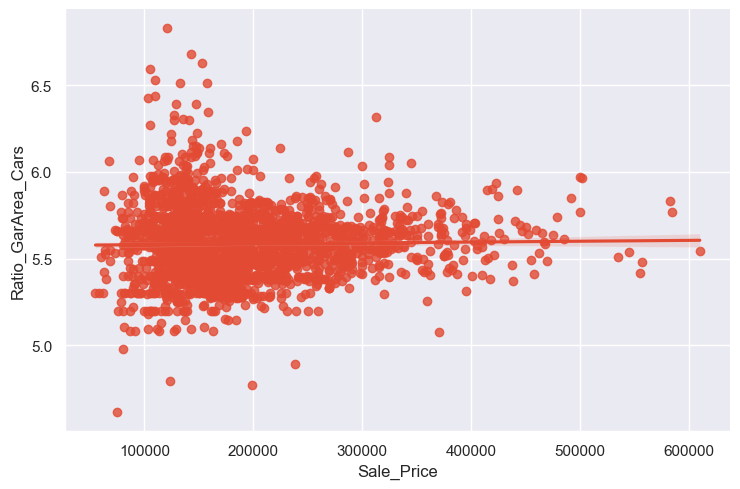

In [108]:
df['Ratio_GarArea_Cars']= np.log1p((df['Garage_Area']/df['Garage_Cars']).fillna(0.0))
df_orig['Ratio_GarArea_Cars']= np.log1p((df_orig['Garage_Area']/df_orig['Garage_Cars']).fillna(0.0))

scatterplot_single(df[df['Garage_Area']>0.0], target='Sale_Price', label='Ratio_GarArea_Cars')

There is an evident trend between the sale price and our new feature, but the fact that many houses do not have a garage and still seem to increase in price can be a problem.

## Basement related features vs Sale Price

### Total Bsmt SF vs Sale Price

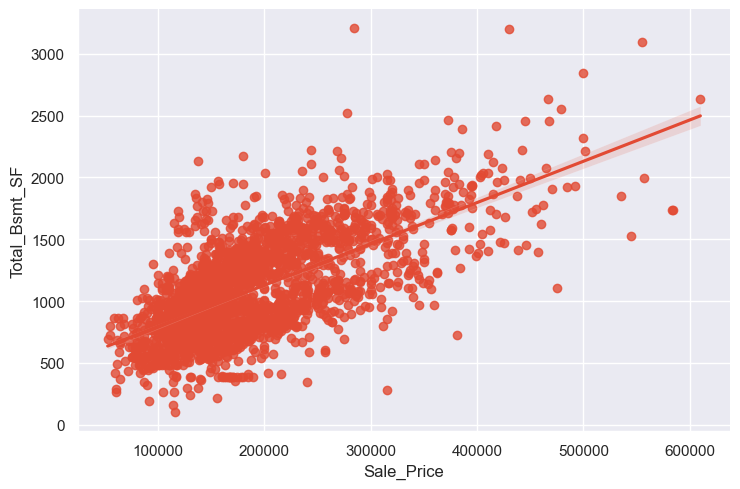

In [109]:
scatterplot_single(df[df['Total_Bsmt_SF']>0.0], 'Sale_Price', 'Total_Bsmt_SF')

### Bsmt_Unf_SF

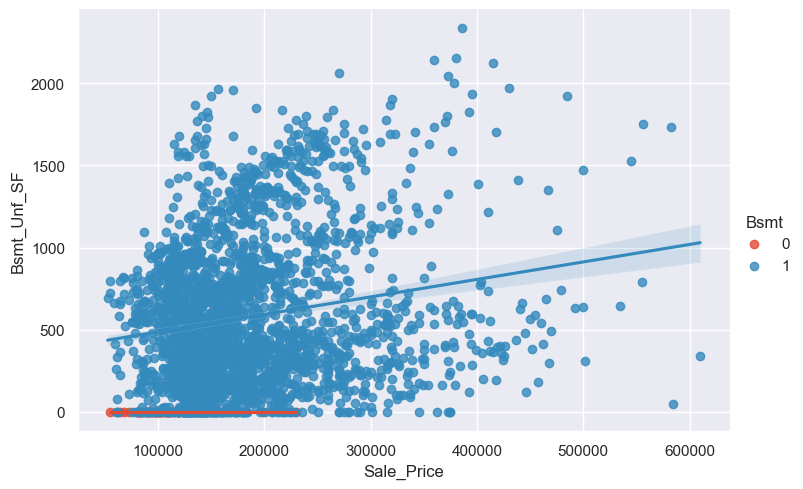

In [110]:
scatterplot_single(df, 'Sale_Price', 'Bsmt_Unf_SF', hue='Bsmt')

We cannot really make a use of it

### Bsmt Fin SF vs Sale Price

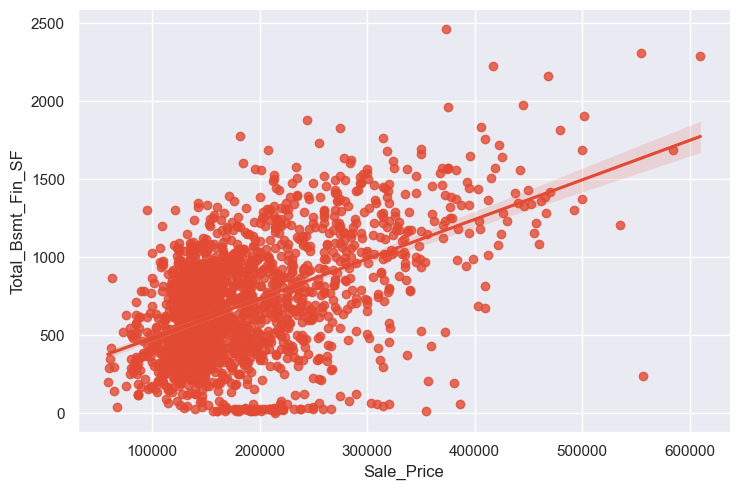

In [111]:
scatterplot_single(df[df['Total_Bsmt_Fin_SF']>0.0], 'Sale_Price', 'Total_Bsmt_Fin_SF')

And again here it seems like we can discard this feature

## External related features vs Sale Price
* Mas_Vnr_Area
* Porch related features
* Deck related features

### Mas_Vnr_Area

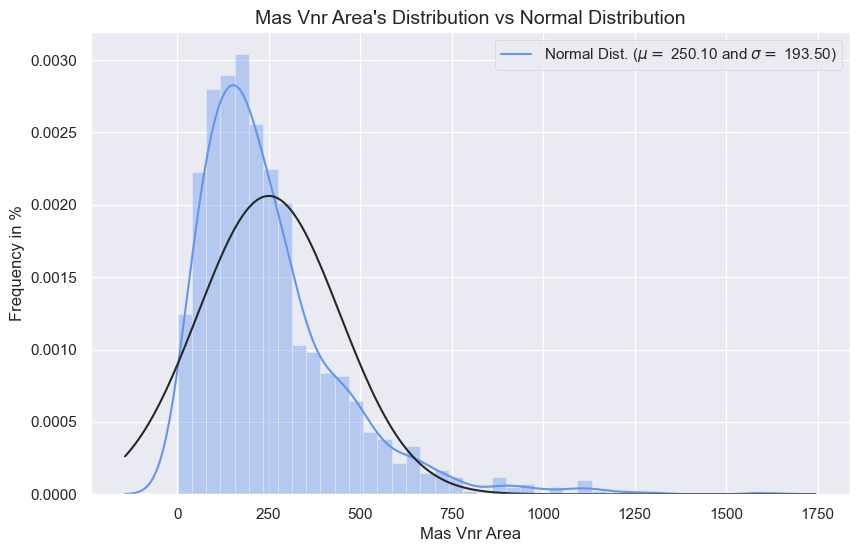

In [112]:
numeric_distr_plot(df.drop(df[df['Mas_Vnr_Area']==0].index.tolist()), 'Mas_Vnr_Area')

This suggests a logarithmic transformation

In [113]:
df['Mas_Vnr_Area'] = np.log1p(df['Mas_Vnr_Area'])
df_orig['Mas_Vnr_Area'] = np.log1p(df_orig['Mas_Vnr_Area'])

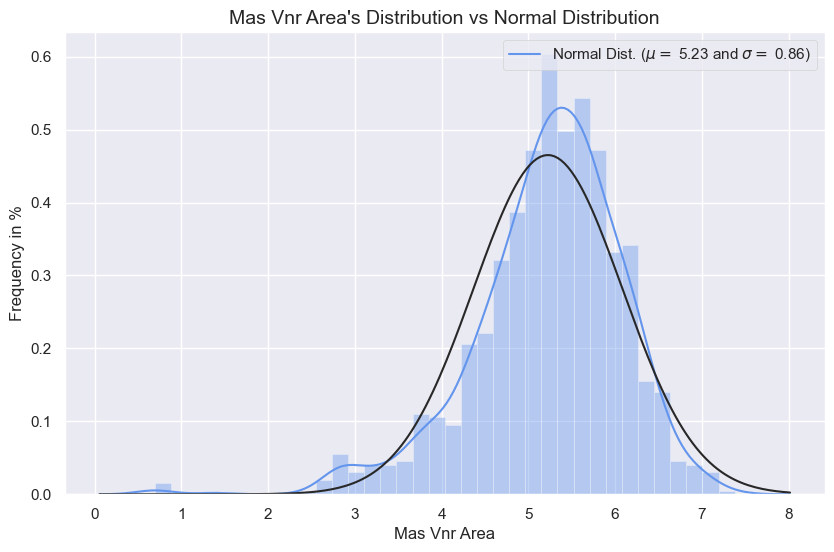

In [114]:
numeric_distr_plot(df.drop(df[df['Mas_Vnr_Area']==0].index.tolist()), 'Mas_Vnr_Area')

In [115]:
df['Mas_Vnr'] = df.apply(lambda x: 0 if (x['Mas_Vnr_Area']<=0.0) else 1 ,axis=1)
df_orig['Mas_Vnr'] = df_orig.apply(lambda x: 0 if (x['Mas_Vnr_Area']<=0.0) else 1 ,axis=1)

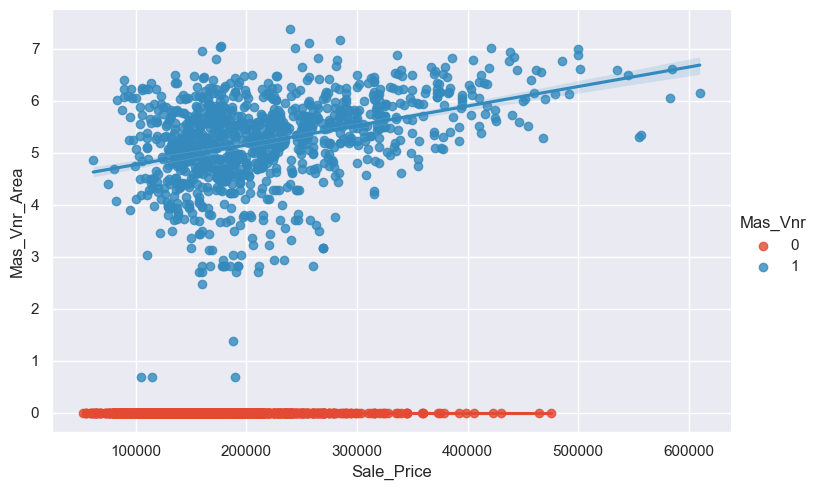

In [116]:
scatterplot_single(df,'Sale_Price', 'Mas_Vnr_Area', hue='Mas_Vnr')

---

### To sum up what we did so far, plus some ideas for later

We performed an exteded analysis on the dataset and added some new features which really are logarithm transfomations of the original ones. Then we started looking at the outliers and removed the ones which looked very far away from the highlighted trends. We added indicators which might be useful for models like the linear ones.

We showed that there might be signals of correlation at some n-dim level in this dataset, but that can be only clear with a more profound look at the data.

Next we need to understand what features are usable for our prediction, encode the categorical ones and perform standardization/normalization for the models which need it.

---

### Save the dataset

In [117]:
df.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_1.csv"))
df_orig.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_1_orig.csv"))

---

#### Credits and References
* Thomas Schmitt, [house_prices](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active). OpenML (2019).(accessed April 12, 2023)
* E.J. Martin, [How much is my house worth? A beginner's guide]( https://www.bankrate.com/real-estate/how-much-is-my-house-worth/#faq). Bankrate (2023). (accessed April 12, 2023).
* J. Gomez, [8 critical factors that influence a home’s value](https://www.opendoor.com/articles/factors-that-influence-home-value). Opendoor (4 June 2022). (accessed April 12, 2023).
* [Ames (Iowa)](https://it.wikipedia.org/wiki/Ames_(Iowa)), Wikipedia (2020). (accessed April 12, 2023).
*  Leeclemmer, [Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/code/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa). Kaggle (2017). (accessed April 18, 2023).
* Alvin T. Tan, [Cracking the Ames Housing Dataset with Linear Regression](https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96). Towards Data Science (2022). (accessed April 19, 2023).
* The Strategic Plan For North Richland Hill, [Land Use Categories](https://www.nrhtx.com/DocumentCenter/View/9222/Draft-Land-Use-Categories?bidId=). North Richland Hills, TX. (accessed April 19, 2023
* [Abnormal Sale](https://payrollheaven.com/define/abnormal-sale/). PayrollHeaven.com. Payroll & Accounting Heaven Ltd. (accessed April 19, 2023).
* Benjamin Dornel, [Project 2: Predicting Housing Prices with Linear Regression](https://www.benjamindornel.com/ames-regression.html). (accessed April 20, 2023).
* Serigne, [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard). Kaggle (2017). (accessed April 20, 2023).
* Gkitchen, [Gimme Shelter 🏠 SCORE 0.12630](https://www.kaggle.com/code/gkitchen/gimme-shelter-score-0-12630). Kaggle (2017). (accessed April 20, 2023).
* Hussein Ali, [House Price - Advanced Regression](https://www.kaggle.com/code/thisishusseinali/house-price-advanced-regression). Kaggle (2017). (accessed April 20, 2023).
* Rushikesh Sawarkar, [House Prices - Pipeline, Ensemble Models](https://www.kaggle.com/code/rushikeshsawarkar/0-12018-house-prices-pipeline-ensemble-models). Kaggle (2017). (accessed April 20, 2023).
* J. Ostrowski, [What is the best time of year to sell a house?](https://www.bankrate.com/real-estate/best-time-to-sell-house/) Bankrate (2022). (accessed April 20, 2023).